In [209]:
# https://chatgpt.com/share/1b389c48-aae8-4017-bf4d-ed3cbce74439

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from keras.callbacks import EarlyStopping, Callback
from sklearn.model_selection import train_test_split, ParameterGrid
from keras.models import load_model
import joblib
import os
import random
from keras.utils import plot_model


### Previsione prezzi

In [3]:
# Carica i dati storici dei prezzi di Bitcoin
data = pd.read_csv(r'C:\Users\Alessandro\Desktop\Cartelle\Mie\Programmi personali in Python\Kaggle\Bitcoin Historical Dataset\Bitcoin (€) da yfinance dal 17-09-2014 al 09-05-2024 con granularità giornaliera.csv')
data = data[['Date', 'Close']]
data

,Date,Close
0,2014-09-17 00:00:00+00:00,355.957367
1,2014-09-18 00:00:00+00:00,328.539368
2,2014-09-19 00:00:00+00:00,307.761139
3,2014-09-20 00:00:00+00:00,318.758972
4,2014-09-21 00:00:00+00:00,310.632446
...,...,...
3518,2024-05-05 00:00:00+00:00,59332.816406
3519,2024-05-06 00:00:00+00:00,59517.320312
3520,2024-05-07 00:00:00+00:00,58643.468750
3521,2024-05-08 00:00:00+00:00,57986.964844


In [212]:
# # Normalizza i prezzi
# scaler = MinMaxScaler(feature_range=(0, 1))
# prices_normalized = scaler.fit_transform(prices)

# # Creazione delle sequenze
# def create_sequences(data, time_step=1):
#     X, y = [], []
#     for i in range(len(data) - time_step):
#         X.append(data[i:(i + time_step), 0])
#         y.append(data[i + time_step, 0])
#     return np.array(X), np.array(y)

# time_step = 60
# X, y = create_sequences(prices_normalized, time_step)
# X = X.reshape(X.shape[0], X.shape[1], 1)

# # Dividi i dati in set di addestramento e test
# train_size = int(len(X) * 0.8)
# test_size = len(X) - train_size
# X_train, X_test = X[:train_size], X[train_size:]
# y_train, y_test = y[:train_size], y[train_size:]

# # Costruisci il modello LSTM
# model = Sequential()
# model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
# model.add(LSTM(50, return_sequences=False))
# model.add(Dense(25))
# model.add(Dense(1, activation='sigmoid'))

# # Compila e addestra il modello
# model.compile(optimizer='adam', loss='mean_squared_error')
# model.fit(X_train, y_train, batch_size=1, epochs=20)

# # Previsione e valutazione
# predicted_prices = model.predict(X_test)
# predicted_prices = scaler.inverse_transform(predicted_prices)

In [213]:
# Fisso i semi
numpy_seed = 88
tf_seed = 88
random_seed = 88
random_state = 88

np.random.seed(numpy_seed)
tf.random.set_seed(tf_seed)
random.seed(random_seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1' # Alcune operazioni in TensorFlow possono essere eseguite in parallelo, e l’ordine in cui queste operazioni vengono completate può influenzare il risultato. Posso controllare questo impostando l’opzione TF_DETERMINISTIC_OPS su 1


perc_train = 0.8
perc_val = 0.1
time_step = 60

batch_size = 10
max_epochs = 200
LSTM_dim = 150
dense_dim = 100
patience = 5
dropout = 0.2
# Definisco una soglia per identificare una "variazione significativa" nel prezzo
threshold = 0.05 # 5% di variazione del prezzo
funzione_perdita_personalizzata = True


monitor = 'val_loss'
optimizer = 'adam'
loss = 'mean_squared_error'


prices = np.array(data['Close']).reshape(-1, 1)
# Normalizza i prezzi
scaler = MinMaxScaler(feature_range=(0, 1))
prices_normalized = scaler.fit_transform(prices)

# Creazione delle sequenze
def create_sequences(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(prices_normalized, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Dividi i dati in set di addestramento, validazione e test
train_size = int(len(X) * perc_train)
val_size = int(len(X) * perc_val)
test_size = len(X) - train_size - val_size
# X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
# y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]
# quindi così è 0.9, 0.09, 0.01

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size = 1-perc_train-perc_val, random_state = random_state)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size = perc_val/(perc_train+perc_val), random_state = random_state)
# quindi così è 0.9, 0.09, 0.01

# Costruisci il modello LSTM
model = Sequential()
model.add(LSTM(LSTM_dim, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(dropout))  # Aggiungi Dropout dopo il primo strato LSTM
model.add(LSTM(LSTM_dim, return_sequences=False))
model.add(Dropout(dropout))  # Aggiungi Dropout dopo il secondo strato LSTM
model.add(Dense(dense_dim))
model.add(Dense(1, activation='sigmoid'))


def custom_loss(y_true, y_pred):
    # Calcola la differenza assoluta tra il vero valore e la previsione
    absolute_difference = K.abs(y_true - y_pred)
    
    # Calcola una penalità quando la previsione è troppo vicina al valore precedente
    # ma solo se la variazione supera il threshold
    penalty = K.switch(K.greater(absolute_difference, threshold),
                       K.square(absolute_difference),  # Penalità maggiore per grandi differenze
                       K.square(absolute_difference) * 0.1)  # Penalità minore per piccole differenze
    
    return K.mean(penalty, axis=-1)

# Compila il modello con la funzione di perdita personalizzata
if funzione_perdita_personalizzata:
    model.compile(optimizer=optimizer, loss=custom_loss)
else:
    model.compile(optimizer=optimizer, loss=loss)

# Definisci la callback di Early Stopping
early_stopping = EarlyStopping(monitor=monitor, patience=patience, restore_best_weights=True)

# Addestra il modello con la callback di Early Stopping
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=max_epochs, callbacks=[early_stopping], validation_data=(X_val, y_val))

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
277/277 ━━━━━━━━━━━━━━━━━━━━ 30s 84ms/step - loss: 0.0211 - val_loss: 5.4870e-04
Epoch 2/200
277/277 ━━━━━━━━━━━━━━━━━━━━ 24s 85ms/step - loss: 8.6375e-04 - val_loss: 5.3955e-04
Epoch 3/200
277/277 ━━━━━━━━━━━━━━━━━━━━ 23s 84ms/step - loss: 7.2201e-04 - val_loss: 4.4473e-04
Epoch 4/200
277/277 ━━━━━━━━━━━━━━━━━━━━ 24s 85ms/step - loss: 5.4351e-04 - val_loss: 3.0893e-04
Epoch 5/200
277/277 ━━━━━━━━━━━━━━━━━━━━ 24s 86ms/step - loss: 5.8516e-04 - val_loss: 9.1547e-04
Epoch 6/200
277/277 ━━━━━━━━━━━━━━━━━━━━ 23s 84ms/step - loss: 6.0504e-04 - val_loss: 2.8403e-04
Epoch 7/200
277/277 ━━━━━━━━━━━━━━━━━━━━ 25s 92ms/step - loss: 4.4641e-04 - val_loss: 1.5429e-04
Epoch 8/200
277/277 ━━━━━━━━━━━━━━━━━━━━ 24s 86ms/step - loss: 3.1471e-04 - val_loss: 2.4137e-04
Epoch 9/200
277/277 ━━━━━━━━━━━━━━━━━━━━ 25s 89ms/step - loss: 3.6284e-04 - val_loss: 3.1713e-04
Epoch 10/200
277/277 ━━━━━━━━━━━━━━━━━━━━ 25s 89ms/step - loss: 3.3720e-04 - val_loss: 1.4266e-04
Epoch 11/200
277/277 ━━━━━━━━━━━━

In [214]:
modello_da_usare = load_model('Modello con dropout nps88, tfs88, rs88, rst88, bs10, ts60, me200, pt0.8, pv0.1, ld50, dd25, p5, d0.2.h5', custom_objects={'custom_loss': custom_loss})

scaler_da_usare = joblib.load('Scaler da 0 a 1.pkl')

In [215]:
# Previsione
predicted_prices_train = modello_da_usare.predict(X_train)
predicted_prices_train = scaler_da_usare.inverse_transform(predicted_prices_train)

predicted_prices_val = modello_da_usare.predict(X_val)
predicted_prices_val = scaler_da_usare.inverse_transform(predicted_prices_val)

predicted_prices_test = modello_da_usare.predict(X_test)
predicted_prices_test = scaler_da_usare.inverse_transform(predicted_prices_test)

87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [216]:
# # Visualizzo come è fatta la rete neurale salvandola anche come immagine

# # Costruisci il modello LSTM
# model = Sequential()
# model.add(LSTM(LSTM_dim, return_sequences=True, input_shape=(time_step, 1)))
# model.add(LSTM(LSTM_dim, return_sequences=False))
# model.add(Dense(dense_dim))
# model.add(Dense(1, activation='sigmoid'))

# # Crea un diagramma del modello e salvalo come immagine
# plot_model(model, to_file='Rete neurale usata.png', show_shapes=True, show_layer_names=True)

In [217]:
# Salva il modello addestrato
model.save(f'Modello (con dropout e funzione di perdita custom) nps{numpy_seed}, tfs{tf_seed}, rs{random_seed}, rst{random_state}, bs{batch_size}, ts{time_step}, me{max_epochs}, pt{perc_train}, pv{perc_val}, ld{LSTM_dim}, dd{dense_dim}, p{patience}, d{dropout}, th{threshold}, fpp{funzione_perdita_personalizzata}.h5')

# Salva lo scaler
# joblib.dump(scaler, f'Scaler per modello LSTM batch size {batch_size}.pkl')

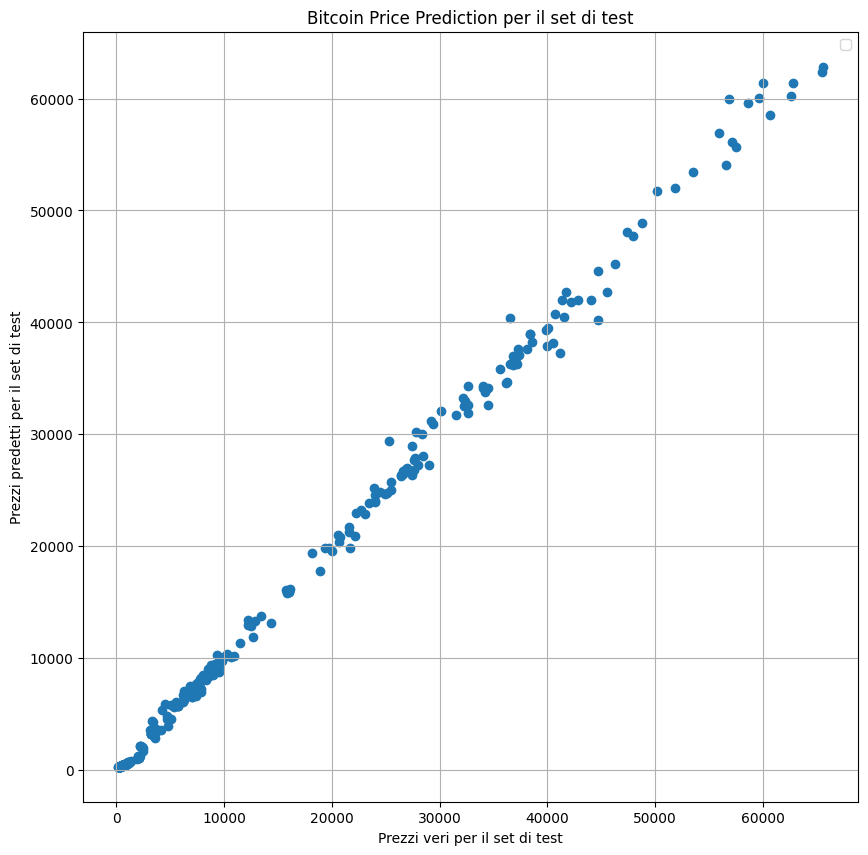

In [218]:
# Visualizza i risultati
plt.figure(figsize=(10,10))
plt.scatter(scaler.inverse_transform(y_test.reshape(-1,1)), predicted_prices_test)
plt.title('Bitcoin Price Prediction per il set di test')
plt.xlabel('Prezzi veri per il set di test')
plt.ylabel('Prezzi predetti per il set di test')
plt.legend()
plt.grid()
plt.show()

In [219]:
# # Visualizza i risultati
# plt.figure(figsize=(20,5))
# plt.plot(prices[len(prices) - len(y_test):], label='True Price')
# plt.plot(predicted_prices, label='Predicted Price')
# plt.title('Bitcoin Price Prediction')
# plt.xlabel('Days')
# plt.ylabel('Price')
# plt.legend()
# plt.grid()
# plt.show()

In [220]:
true_prices_train = (scaler.inverse_transform(y_train.reshape(-1,1)))
predicted_prices_1d_train = predicted_prices_train

# Calcola l'errore quadratico medio
mse = mean_squared_error(true_prices_train, predicted_prices_1d_train)
print(f'Mean Squared Error: {round(mse,2)}')
#489362.13611764833
#489362.14

# Calcola il MAPE
mape = mean_absolute_percentage_error(true_prices_train, predicted_prices_1d_train)
print(f'Mean Absolute Percentage Error (MAPE): {round(mape * 100,2)}%')
#9.652234765905282
#9.65

# Calcola il MAE
mae = mean_absolute_error(true_prices_train, predicted_prices_1d_train)
print(f'Mean Absolute Error (MAE): {round(mae,2)}')
#365.01
#365.01

Mean Squared Error: 709681.84
Mean Absolute Percentage Error (MAPE): 10.99%
Mean Absolute Error (MAE): 488.84


In [221]:
true_prices_val = (scaler.inverse_transform(y_val.reshape(-1,1)))
predicted_prices_1d_val = predicted_prices_val

# Calcola l'errore quadratico medio
mse = mean_squared_error(true_prices_val, predicted_prices_1d_val)
print(f'Mean Squared Error: {round(mse,2)}')
#489362.13611764833
#489362.14

# Calcola il MAPE
mape = mean_absolute_percentage_error(true_prices_val, predicted_prices_1d_val)
print(f'Mean Absolute Percentage Error (MAPE): {round(mape * 100,2)}%')
#9.652234765905282
#9.65

# Calcola il MAE
mae = mean_absolute_error(true_prices_val, predicted_prices_1d_val)
print(f'Mean Absolute Error (MAE): {round(mae,2)}')
#365.01
#365.01

Mean Squared Error: 753636.74
Mean Absolute Percentage Error (MAPE): 10.64%
Mean Absolute Error (MAE): 500.09


In [222]:
true_prices_test = (scaler.inverse_transform(y_test.reshape(-1,1)))
predicted_prices_1d_test = predicted_prices_test

# Calcola l'errore quadratico medio
mse = mean_squared_error(true_prices_test, predicted_prices_1d_test)
print(f'Mean Squared Error: {round(mse,2)}')
#489362.13611764833
#489362.14

# Calcola il MAPE
mape = mean_absolute_percentage_error(true_prices_test, predicted_prices_1d_test)
print(f'Mean Absolute Percentage Error (MAPE): {round(mape * 100,2)}%')
#9.652234765905282
#9.65

# Calcola il MAE
mae = mean_absolute_error(true_prices_test, predicted_prices_1d_test)
print(f'Mean Absolute Error (MAE): {round(mae,2)}')
#365.01
#365.01

Mean Squared Error: 696661.16
Mean Absolute Percentage Error (MAPE): 12.27%
Mean Absolute Error (MAE): 479.49


In [223]:
def predict_prices(sequence, model, scaler, time_step):
    predicted_prices = []
    # Controlla se la sequenza è abbastanza lunga per fare almeno una previsione
    if len(sequence) < time_step:
        raise ValueError(f"La sequenza deve contenere almeno {time_step} elementi per fare una previsione.")
    
    # Calcola il numero di previsioni da fare
    num_predictions = len(sequence) - time_step
    
    for i in range(num_predictions + 1):
        # Estrai la sotto-sequenza corrente
        current_sequence = sequence[i:i+time_step]
        
        # Normalizza la sotto-sequenza
        current_sequence = np.array(current_sequence).reshape(-1, 1)
        current_sequence_normalized = scaler.transform(current_sequence)
        
        # Ridimensiona per il modello
        current_sequence_normalized = current_sequence_normalized.reshape(1, time_step, 1)
        
        # Previsione
        predicted_normalized_price = model.predict(current_sequence_normalized)
        
        # Inverti la normalizzazione
        predicted_price = scaler.inverse_transform(predicted_normalized_price)
        
        # Aggiungi il prezzo previsto alla lista dei prezzi previsti
        predicted_prices.append(predicted_price[0,0])
    
    return predicted_prices

In [224]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

# Leggi il file CSV esistente
data_esistente = pd.read_csv("Bitcoin (€) da yfinance dal 17-09-2014 al 09-05-2024 con granularità giornaliera.csv")

# Trova l'ultima data nel file CSV esistente
ultima_data = pd.to_datetime(data_esistente['Date']).max()

# Calcola la data di inizio per i nuovi dati
data_inizio = (ultima_data + timedelta(days=1)).strftime('%Y-%m-%d')

# Scarica i dati di Bitcoin in EUR
btc = yf.Ticker("BTC-EUR")

# Scarica i dati storici con intervallo giornaliero
data = btc.history(start=data_inizio, end=datetime.now().strftime('%Y-%m-%d'), interval='1d')

# Resetta l'indice
data = data.reset_index()

# Concatena i nuovi dati con quelli esistenti
dati_completi = pd.concat([data_esistente, data])

if "Unnamed: 0" in dati_completi.columns:
    dati_completi.drop(columns='Unnamed: 0', inplace=True)

dati_completi = dati_completi.reset_index(drop=True)
dati_completi

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2014-09-17 00:00:00+00:00,359.546204,361.468506,351.586884,355.957367,16389166,0.0,0.0
1,2014-09-18 00:00:00+00:00,355.588409,355.505402,319.789459,328.539368,26691849,0.0,0.0
2,2014-09-19 00:00:00+00:00,328.278503,330.936707,298.921021,307.761139,29560103,0.0,0.0
3,2014-09-20 00:00:00+00:00,307.665253,329.978180,303.931244,318.758972,28736826,0.0,0.0
4,2014-09-21 00:00:00+00:00,318.120514,321.504517,306.502197,310.632446,20702625,0.0,0.0
...,...,...,...,...,...,...,...,...
3547,2024-06-03 00:00:00+00:00,62368.406250,63012.160156,62034.824219,62428.628906,15766277926,0.0,0.0
3548,2024-06-04 00:00:00+00:00,62430.742188,64715.664062,62274.976562,63082.285156,29706470423,0.0,0.0
3549,2024-06-05 00:00:00+00:00,63082.089844,65270.683594,63059.175781,64847.828125,30462714742,0.0,0.0
3550,2024-06-06 00:00:00+00:00,64848.363281,66078.859375,64785.851562,65369.968750,30173802522,0.0,0.0


In [225]:
dati_completi = dati_completi[['Date', 'Close']]
dati_completi

,Date,Close
0,2014-09-17 00:00:00+00:00,355.957367
1,2014-09-18 00:00:00+00:00,328.539368
2,2014-09-19 00:00:00+00:00,307.761139
3,2014-09-20 00:00:00+00:00,318.758972
4,2014-09-21 00:00:00+00:00,310.632446
...,...,...
3547,2024-06-03 00:00:00+00:00,62428.628906
3548,2024-06-04 00:00:00+00:00,63082.285156
3549,2024-06-05 00:00:00+00:00,64847.828125
3550,2024-06-06 00:00:00+00:00,65369.968750


In [226]:
time_step = 60

# Utilizzo della funzione
sequence_to_predict = dati_completi['Close'].iloc[-100:].reset_index(drop=True)
prices_predicted = predict_prices(sequence_to_predict, modello_da_usare, scaler_da_usare, time_step)
print(f"I prezzi previsti sono: {prices_predicted}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━

In [227]:
sequence_to_predict

0     57669.230469
1     56633.839844
2     57573.386719
3     57194.621094
4     58261.414062
          ...     
95    62428.628906
96    63082.285156
97    64847.828125
98    65369.968750
99    64964.207031
Name: Close, Length: 100, dtype: float64

In [228]:
def plot_predicted_vs_real(prices_real, prices_predicted, time_step):
    # Verifica che la sequenza dei prezzi reali sia sufficientemente lunga
    if len(prices_real) < time_step + 2:
        raise ValueError(f"La sequenza dei prezzi reali deve contenere almeno {time_step + 2} elementi.")
    
    # Calcola l'indice da cui iniziare il plot dei prezzi predetti
    start_index = time_step
    end_index = start_index + len(prices_predicted)
    
    # Crea il plot
    plt.figure(figsize=(12,6))
    plt.plot(prices_real, label='Prezzi Reali', color='blue')
    plt.plot(range(start_index, end_index), prices_predicted, label='Prezzi Predetti', color='red')
    
    # Aggiungi titolo e legenda
    plt.title('Confronto Prezzi Predetti vs Prezzi Reali')
    plt.xlabel('Tempo')
    plt.ylabel('Prezzo')
    plt.legend()
    plt.grid()
    plt.show()

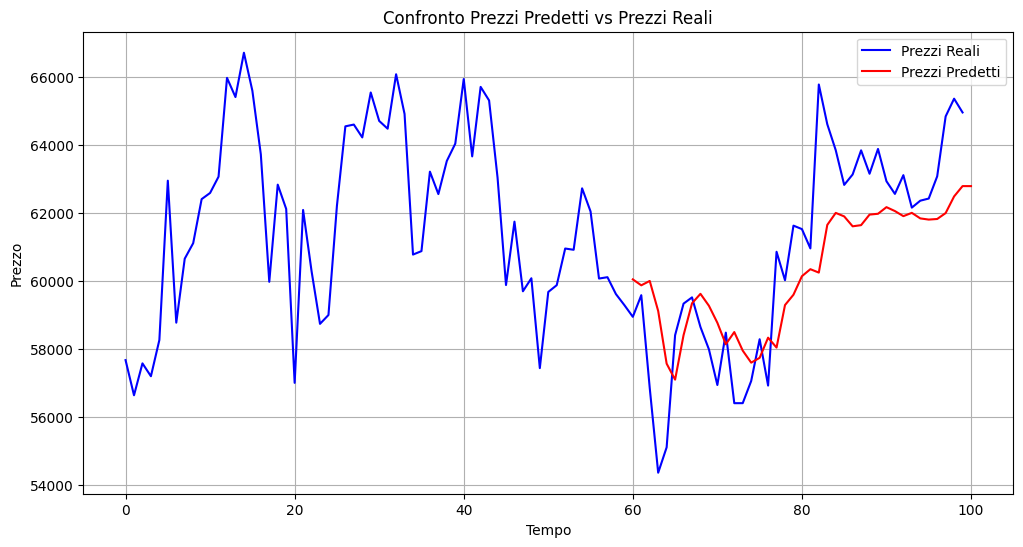

In [229]:
# Utilizzo della funzione
prices_real = sequence_to_predict # [sequenza dei prezzi reali]
prices_predicted = prices_predicted #[lista dei prezzi predetti dalla tua funzione di previsione]
plot_predicted_vs_real(prices_real, prices_predicted, time_step)

In [230]:
def plot_predicted_vs_real_shifted(prices_real, prices_predicted, time_step):
    # Verifica che la sequenza dei prezzi reali sia sufficientemente lunga
    if len(prices_real) < time_step + 2:
        raise ValueError(f"La sequenza dei prezzi reali deve contenere almeno {time_step + 2} elementi.")
    
    # Calcola l'indice da cui iniziare il plot dei prezzi predetti
    start_index = time_step - 1  # Shift di -1
    end_index = start_index + len(prices_predicted)
    
    # Crea il plot
    plt.figure(figsize=(12,6))
    plt.plot(prices_real, label='Prezzi Reali', color='blue')
    plt.plot(range(start_index, end_index), prices_predicted, label='Prezzi Predetti', color='red')
    
    # Aggiungi titolo e legenda
    plt.title('Confronto Prezzi Predetti (Shiftati) vs Prezzi Reali')
    plt.xlabel('Tempo')
    plt.ylabel('Prezzo')
    plt.legend()
    plt.grid()
    plt.show()

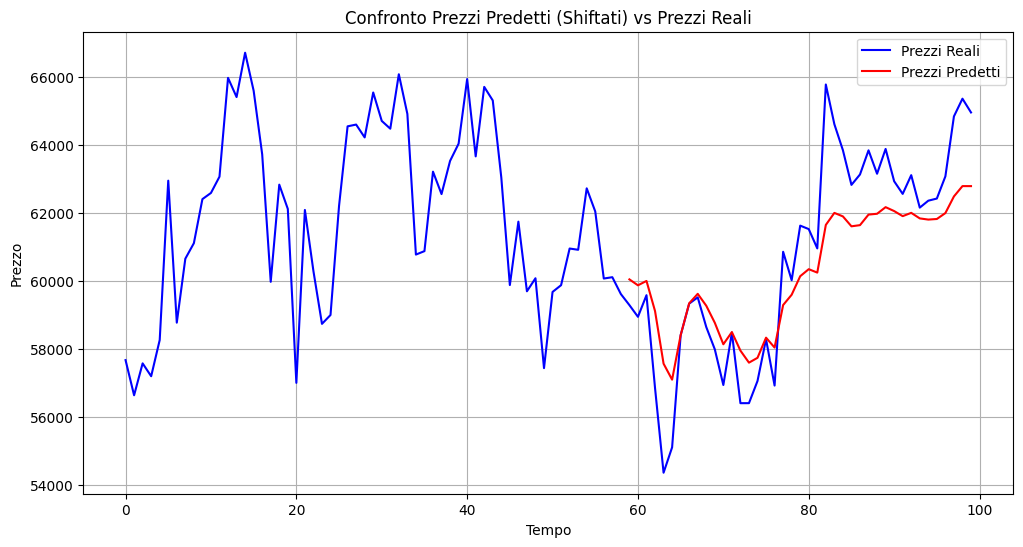

In [231]:
# Utilizzo della funzione
prices_real = sequence_to_predict # [sequenza dei prezzi reali]
prices_predicted = prices_predicted #[lista dei prezzi predetti dalla tua funzione di previsione]
plot_predicted_vs_real_shifted(prices_real, prices_predicted, time_step)

### Roba successiva da riguardare

In [232]:
# Previsione a gruppi di time_step
X_test_generico = (np.array(data['Close'].iloc[:])).reshape(-1, 1)
y_test_generico = data['Close'].iloc[time_step:]

predicted_prices = []
for i in range(len(X_test_generico) - time_step):
    test_sequence = X_test_generico[i:i + time_step]
    test_sequence = scaler.transform(test_sequence).reshape(1, time_step, 1)
    price = model.predict(test_sequence)
    predicted_prices.append(scaler.inverse_transform(price))
    print(f'Ho predetto {i+1}/{len(X_test_generico) - time_step} prezzi')

# Converti la lista in un array numpy per il plotting
predicted_prices = np.array(predicted_prices)

# Previsione sui dati completi
# predicted_full = model.predict(X)
# predicted_full = scaler.inverse_transform(predicted_full)

In [233]:
predicted_prices.flatten()

array([], dtype=float64)

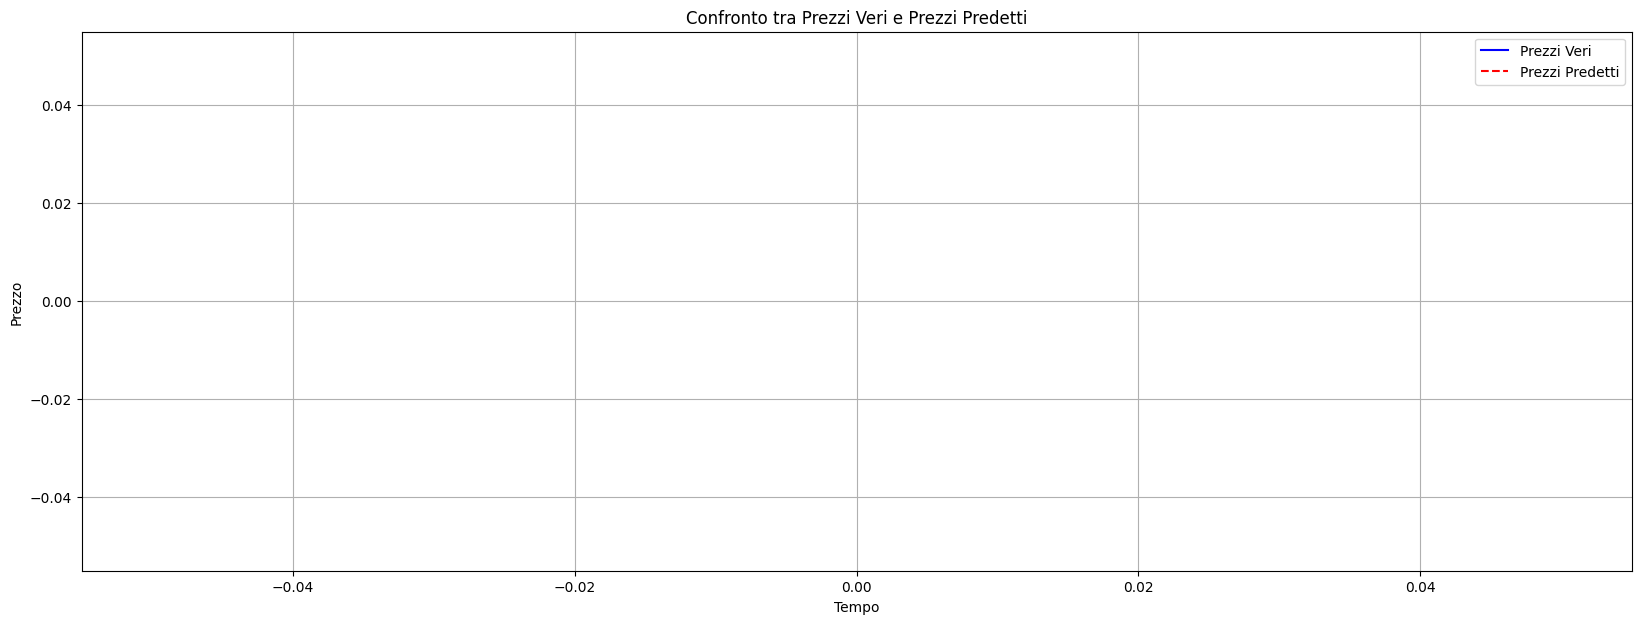

In [234]:
# Grafico di confronto
plt.figure(figsize=(20, 7))
plt.plot(y_test_generico, color='blue', label='Prezzi Veri')
plt.plot(predicted_prices.flatten(), color='red', linestyle='--', label='Prezzi Predetti')
plt.title('Confronto tra Prezzi Veri e Prezzi Predetti')
plt.xlabel('Tempo')
plt.ylabel('Prezzo')
plt.legend()
plt.grid()
plt.show()

In [235]:
true_prices_generico = (scaler.inverse_transform(y_test_generico.reshape(-1,1))).flatten()
predicted_prices_1d_test = predicted_prices.flatten()

# Calcola l'errore quadratico medio
mse = mean_squared_error(true_prices_generico, predicted_prices_1d_test)
print(f'Mean Squared Error: {mse}')
#659663.7110657709

# Calcola il MAPE
mape = mean_absolute_percentage_error(true_prices_generico, predicted_prices_1d_test)
print(f'Mean Absolute Percentage Error (MAPE): {mape * 100}%')
#12.405588192643274

AttributeError: 'Series' object has no attribute 'reshape'

In [ ]:
# # Assumi che 'prices' sia la serie dei prezzi reali e 'predicted_prices' quella dei prezzi previsti
# true_prices = prices[len(prices) - len(y_test):].flatten()
# predicted_prices_1d = predicted_prices.flatten()

# # Calcola l'errore quadratico medio
# mse = mean_squared_error(true_prices, predicted_prices_1d)
# print(f'Mean Squared Error: {mse}')
# #8499445.36926863

# # Calcola il MAPE
# mape = mean_absolute_percentage_error(true_prices, predicted_prices_1d)
# print(f'Mean Absolute Percentage Error (MAPE): {mape * 100}%')
# #4.099629991046934

In [ ]:
data['Daily_return'] = data['Close'].pct_change()
data['State'] = np.where((data['Daily_return'] >= 0) & data['Daily_return'].notna(), 1, np.where(data['Daily_return'].notna(), 0, float('nan')))

# Inizializza la nuova colonna con NaN
data['Predicted prices'] = np.nan

# Calcola l'indice di inizio per l'assegnazione dei valori
start_idx = len(data) - len(predicted_prices)

# Assegna i valori di predicted_prices alla fine della colonna 'Predicted prices'
data.loc[start_idx:, 'Predicted prices'] = np.array(predicted_prices)


data['Daily_return predicted prices'] = data['Predicted prices'].pct_change()
data['State of predicted prices'] = np.where((data['Daily_return predicted prices'] >= 0) & data['Daily_return predicted prices'].notna(), 1, np.where(data['Daily_return predicted prices'].notna(), 0, float('nan')))
data

,Date,Close,Daily_return,State,Predicted prices,Daily_return predicted prices,State of predicted prices
0,2014-09-17 00:00:00+00:00,355.957367,NaN,NaN,NaN,NaN,NaN
1,2014-09-18 00:00:00+00:00,328.539368,-0.077026,0.0,NaN,NaN,NaN
2,2014-09-19 00:00:00+00:00,307.761139,-0.063244,0.0,NaN,NaN,NaN
3,2014-09-20 00:00:00+00:00,318.758972,0.035735,1.0,NaN,NaN,NaN
4,2014-09-21 00:00:00+00:00,310.632446,-0.025494,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...
3518,2024-05-05 00:00:00+00:00,59332.816406,0.015927,1.0,722.994934,-0.980682,0.0
3519,2024-05-06 00:00:00+00:00,59517.320312,0.003110,1.0,3523.236572,3.873114,1.0
3520,2024-05-07 00:00:00+00:00,58643.468750,-0.014682,0.0,3719.706543,0.055764,1.0
3521,2024-05-08 00:00:00+00:00,57986.964844,-0.011195,0.0,22858.632812,5.145279,1.0


In [ ]:
dati_solo_previsioni = data[-len(predicted_prices)+1:].reset_index(drop=True)
dati_solo_previsioni

,Date,Close,Daily_return,State,Predicted prices,Daily_return predicted prices,State of predicted prices
0,2024-04-06 00:00:00+00:00,62559.875000,-0.010450,0.0,32673.550781,73.089751,1.0
1,2024-04-07 00:00:00+00:00,63535.992188,0.015603,1.0,5671.386719,-0.826423,0.0
2,2024-04-08 00:00:00+00:00,64045.218750,0.008015,1.0,534.818665,-0.905699,0.0
3,2024-04-09 00:00:00+00:00,65948.554688,0.029719,1.0,10049.384766,17.790266,1.0
4,2024-04-10 00:00:00+00:00,63670.394531,-0.034545,0.0,12207.900391,0.214791,1.0
5,2024-04-11 00:00:00+00:00,65717.312500,0.032149,1.0,778.740234,-0.936210,0.0
6,2024-04-12 00:00:00+00:00,65317.503906,-0.006084,0.0,2320.073975,1.979266,1.0
7,2024-04-13 00:00:00+00:00,63046.519531,-0.034768,0.0,37691.660156,15.245887,1.0
8,2024-04-14 00:00:00+00:00,59880.496094,-0.050217,0.0,3406.808838,-0.909614,0.0
9,2024-04-15 00:00:00+00:00,61747.792969,0.031184,1.0,41605.335938,11.212407,1.0


In [ ]:
dati_solo_previsioni['Stati coincidenti'] = np.where((dati_solo_previsioni['State'] == dati_solo_previsioni['State of predicted prices']), 1, 0)
dati_solo_previsioni['Stati coincidenti -1'] = np.where((dati_solo_previsioni['State'] == dati_solo_previsioni['State of predicted prices'].shift(-1)), 1, 0) # vale 1 se lo stato del giorno attuale coincide con lo stato predetto per il giorno successivo

dati_solo_previsioni

,Date,Close,Daily_return,State,Predicted prices,Daily_return predicted prices,State of predicted prices,Stati coincidenti,Stati coincidenti -1
0,2024-04-06 00:00:00+00:00,62559.875000,-0.010450,0.0,32673.550781,73.089751,1.0,0,1
1,2024-04-07 00:00:00+00:00,63535.992188,0.015603,1.0,5671.386719,-0.826423,0.0,0,0
2,2024-04-08 00:00:00+00:00,64045.218750,0.008015,1.0,534.818665,-0.905699,0.0,0,1
3,2024-04-09 00:00:00+00:00,65948.554688,0.029719,1.0,10049.384766,17.790266,1.0,1,1
4,2024-04-10 00:00:00+00:00,63670.394531,-0.034545,0.0,12207.900391,0.214791,1.0,0,1
5,2024-04-11 00:00:00+00:00,65717.312500,0.032149,1.0,778.740234,-0.936210,0.0,0,1
6,2024-04-12 00:00:00+00:00,65317.503906,-0.006084,0.0,2320.073975,1.979266,1.0,0,0
7,2024-04-13 00:00:00+00:00,63046.519531,-0.034768,0.0,37691.660156,15.245887,1.0,0,1
8,2024-04-14 00:00:00+00:00,59880.496094,-0.050217,0.0,3406.808838,-0.909614,0.0,1,0
9,2024-04-15 00:00:00+00:00,61747.792969,0.031184,1.0,41605.335938,11.212407,1.0,1,0


In [ ]:
accuratezza = sum(dati_solo_previsioni['Stati coincidenti']) / len(dati_solo_previsioni)
accuratezza

0.47058823529411764

In [ ]:
accuratezza_shift_meno1 = sum(dati_solo_previsioni['Stati coincidenti -1'].iloc[:-1]) / len(dati_solo_previsioni['Stati coincidenti -1'].iloc[:-1])
accuratezza_shift_meno1

0.42424242424242425

#### Confronto con i dati previsti shiftati di -1 (cioè tirati "in su" di -1 nella tabella)

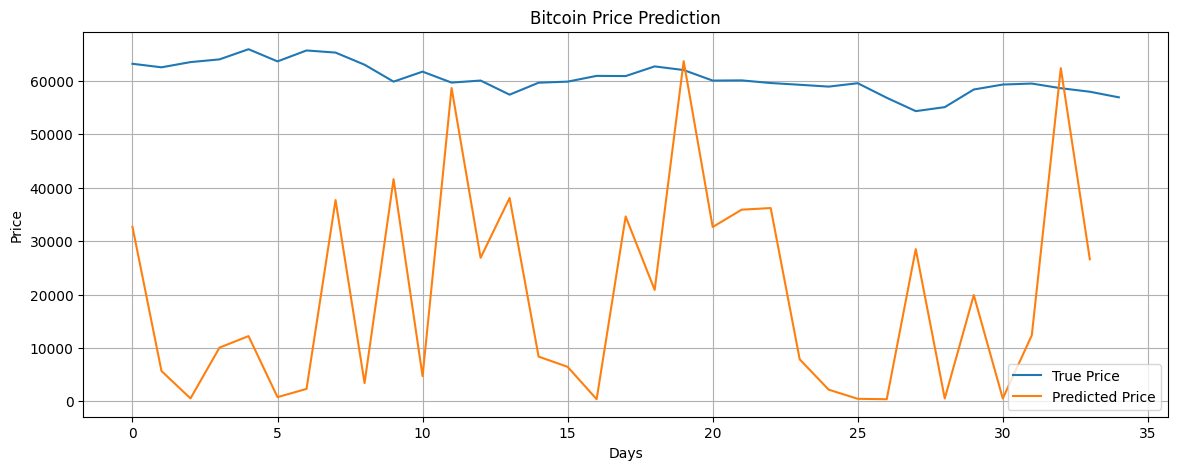

In [ ]:
# Plotto il grafico con i prezzi predetti shiftati di -1 per curiosità

# Assicurati che predicted_prices sia un array NumPy 1D
predicted_prices_1d = np.array(predicted_prices).flatten()

# Crea una Serie pandas da predicted_prices_1d e applica lo shift
predicted_prices_series = pd.Series(predicted_prices_1d).shift(-1)

# Visualizza i risultati
plt.figure(figsize=(14,5))
plt.plot(prices[len(prices) - len(y_test):], label='True Price')
plt.plot(predicted_prices_series, label='Predicted Price')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Rimuovi i NaN dai dati prima di calcolare l'MSE
mask = ~np.isnan(true_prices) & ~np.isnan(predicted_prices_series) # in realtà bastava togliere solo l'ultimo NaN dato che c'è solo l'ultima riga con NaN in predicted_prices_series, ma è la stessa cosa

# Calcolo il MSE
mse = mean_squared_error(true_prices[mask], predicted_prices_series[mask])
print(f'Mean Squared Error: {mse}')

# Calcolo il MAPE
mape = mean_absolute_percentage_error(true_prices[mask], predicted_prices_series[mask])
print(f'Mean Absolute Percentage Error (MAPE): {mape * 100}%')

ValueError: operands could not be broadcast together with shapes (36,) (35,) 

#### Prevedo diversi prezzi futuri usando come passato anche i prezzi già predetti

In [ ]:
# modello_da_usare = load_model(f'Modello LSTM batch size {batch_size}.h5')
modello_da_usare = load_model('Modello LSTM nps8, tfs8, rs8, bs10, ts60, me200, pt0.9, pv0.09, ld50, dd25, p5.h5')

scaler_da_usare = joblib.load(f'Scaler da 0 a 1.pkl')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


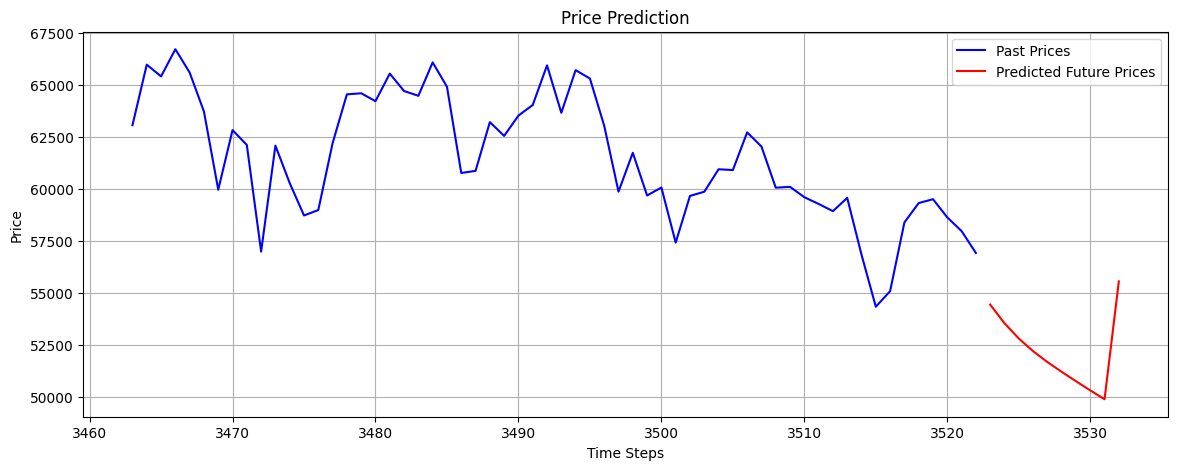

In [ ]:
# Imposta il numero di prezzi futuri da prevedere
prezzi_da_prevedere = 10

# Prendi gli ultimi time_step prezzi come punto di partenza per le previsioni
ultimi_prezzi = np.array(data['Close'].iloc[-time_step:])

# Lista per raccogliere i prezzi previsti
prezzi_previsti = []

# Loop per prevedere i prezzi futuri
for _ in range(prezzi_da_prevedere):
    # Normalizza gli ultimi prezzi usando lo scaler già addestrato
    ultimi_prezzi_normalizzati = scaler_da_usare.transform(ultimi_prezzi.reshape(-1, 1))
    
    # Crea la sequenza di input per il modello
    X_pred = ultimi_prezzi_normalizzati.reshape((1, time_step, 1))
    
    # Prevedi il prezzo successivo
    prezzo_previsto_normalizzato = modello_da_usare.predict(X_pred)
    
    # Inverti la normalizzazione per ottenere il prezzo previsto nella scala originale
    prezzo_previsto = scaler_da_usare.inverse_transform(prezzo_previsto_normalizzato)[0, 0]
    
    # Aggiungi il prezzo previsto alla lista dei prezzi previsti
    prezzi_previsti.append(prezzo_previsto)
    
    # Aggiorna gli ultimi prezzi includendo il prezzo previsto e rimuovendo il più vecchio
    ultimi_prezzi = np.append(ultimi_prezzi[1:], prezzo_previsto)

# Shifta i prezzi previsti di -1
prezzi_previsti_shiftati = np.roll(prezzi_previsti, -1)

# Visualizza i risultati
plt.figure(figsize=(14,5))
plt.plot(data['Close'].iloc[-time_step:], label='Past Prices', color='blue')
plt.plot(np.arange(len(data), len(data) + len(prezzi_previsti_shiftati)), prezzi_previsti_shiftati, label='Predicted Future Prices', color='red')
plt.title('Price Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

In [ ]:
prezzi_previsti

[55570.1,
 54456.125,
 53558.418,
 52826.066,
 52217.49,
 51696.285,
 51224.684,
 50774.08,
 50333.85,
 49908.42]

#### Prevedo il prezzo successivo ai time_step dati che dico io (eventualmente più gruppi di time_step dati)

In [ ]:
dati_generici = pd.read_csv('Bitcoin (€) da yfinance dal 17-09-2014 al 05-06-2024 con granularità giornaliera.csv')
dati_generici = dati_generici[['Date', 'Close']]
dati_generici

,Date,Close
0,2014-09-17 00:00:00+00:00,355.957367
1,2014-09-18 00:00:00+00:00,328.539368
2,2014-09-19 00:00:00+00:00,307.761139
3,2014-09-20 00:00:00+00:00,318.758972
4,2014-09-21 00:00:00+00:00,310.632446
...,...,...
3545,2024-06-01 00:00:00+00:00,62161.078125
3546,2024-06-02 00:00:00+00:00,62365.332031
3547,2024-06-03 00:00:00+00:00,62428.628906
3548,2024-06-04 00:00:00+00:00,63082.285156


In [ ]:
indice = 64 # Dev'essere almeno time_step+1
dati_generici = dati_generici[-indice:].reset_index(drop=True)
dati_generici

,Date,Close
0,2024-04-03 00:00:00+00:00,60778.117188
1,2024-04-04 00:00:00+00:00,60879.437500
2,2024-04-05 00:00:00+00:00,63220.507812
3,2024-04-06 00:00:00+00:00,62559.875000
4,2024-04-07 00:00:00+00:00,63535.992188
...,...,...
59,2024-06-01 00:00:00+00:00,62161.078125
60,2024-06-02 00:00:00+00:00,62365.332031
61,2024-06-03 00:00:00+00:00,62428.628906
62,2024-06-04 00:00:00+00:00,63082.285156


In [ ]:
modello_da_usare = load_model('Modello LSTM nps8, tfs8, rs8, bs10, ts60, me200, pt0.9, pv0.09, ld50, dd25, p5.h5')

scaler_da_usare = joblib.load(f'Scaler da 0 a 1.pkl')

In [ ]:
def create_sequences(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

In [ ]:
np.array(dati_generici['Close']).reshape(-1, 1)

array([[60778.1171875 ],
       [60879.4375    ],
       [63220.5078125 ],
       [62559.875     ],
       [63535.9921875 ],
       [64045.21875   ],
       [65948.5546875 ],
       [63670.39453125],
       [65717.3125    ],
       [65317.50390625],
       [63046.51953125],
       [59880.49609375],
       [61747.79296875],
       [59696.43359375],
       [60080.52734375],
       [57433.48046875],
       [59676.96484375],
       [59876.7109375 ],
       [60956.07421875],
       [60919.2421875 ],
       [62729.296875  ],
       [62048.1640625 ],
       [60072.16015625],
       [60111.65234375],
       [59615.05078125],
       [59289.60546875],
       [58944.4765625 ],
       [59581.9609375 ],
       [56849.66015625],
       [54352.21484375],
       [55099.96484375],
       [58402.6484375 ],
       [59332.81640625],
       [59517.3203125 ],
       [58643.46875   ],
       [57986.96484375],
       [56935.68359375],
       [58478.08203125],
       [56400.5       ],
       [56401.36328125],


In [ ]:
len(np.array(dati_generici['Close']).reshape(-1, 1))

64

In [ ]:
time_step = 60

# Previsione
X_test_gen, y_test_gen = create_sequences(scaler_da_usare.fit_transform(np.array(dati_generici['Close']).reshape(-1, 1)), time_step)
predicted_prices_gen = modello_da_usare.predict(X_test_gen)
predicted_prices_gen = scaler_da_usare.inverse_transform(predicted_prices_gen)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step


In [ ]:
X_test_gen

array([[0.55413194, 0.56286921, 0.76474932, 0.70778024, 0.79195483,
        0.83586753, 1.        , 0.8035449 , 0.98005904, 0.9455819 ,
        0.74974559, 0.47672639, 0.63775107, 0.46085393, 0.49397591,
        0.26571019, 0.45917506, 0.47639998, 0.56947791, 0.56630173,
        0.72239018, 0.6636533 , 0.49325437, 0.49665994, 0.45383595,
        0.42577147, 0.39600958, 0.45098248, 0.21536496, 0.        ,
        0.06448155, 0.34928552, 0.42949772, 0.44540825, 0.37005244,
        0.31343942, 0.22278312, 0.35579047, 0.17663204, 0.17670648,
        0.23301028, 0.33911731, 0.22139529, 0.56127287, 0.4889393 ,
        0.62765629, 0.61885266, 0.56978175, 0.98612372, 0.88528304,
        0.81928026, 0.73112307, 0.75757774, 0.81889288, 0.75944659,
        0.82244398, 0.74041479, 0.70824678, 0.7558544 , 0.67339034],
       [0.56286921, 0.76474932, 0.70778024, 0.79195483, 0.83586753,
        1.        , 0.8035449 , 0.98005904, 0.9455819 , 0.74974559,
        0.47672639, 0.63775107, 0.46085393, 0.4

In [ ]:
predicted_prices_gen

array([[62056.785],
       [62265.13 ],
       [62359.42 ],
       [63000.25 ]], dtype=float32)

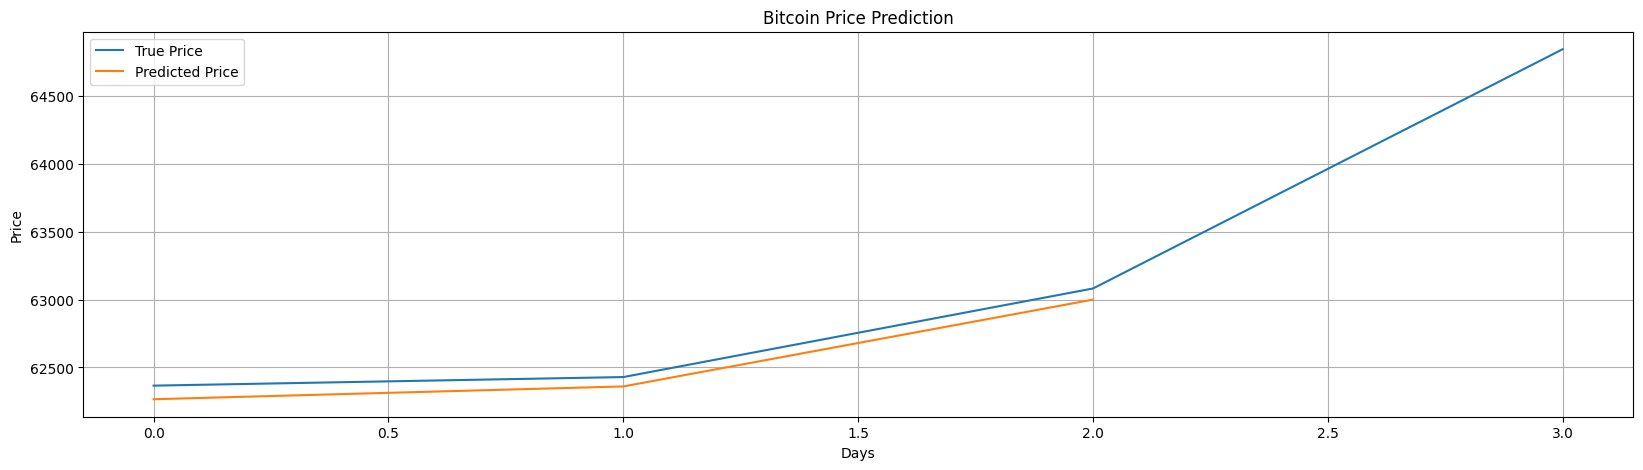

In [ ]:
# Confronto il grafico con i prezzi predetti (shiftati di -1) con i dati generici veri per vedere se performa ancora così bene

# Assicurati che predicted_prices sia un array NumPy 1D
predicted_prices_1d_gen = np.array(predicted_prices_gen).flatten()

# Crea una Serie pandas da predicted_prices_1d e applica lo shift
predicted_prices_series_gen = pd.Series(predicted_prices_1d_gen).shift(-1)

# Visualizza i risultati
plt.figure(figsize=(20,5))
plt.plot(np.arange(len(dati_generici) - time_step), dati_generici['Close'].iloc[-(len(dati_generici) - time_step):], label='True Price')
plt.plot(np.arange(len(dati_generici) - time_step), predicted_prices_series_gen, label='Predicted Price')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Mostro una tabella che mette a confronto su 2 colonne il prezzo vero e il prezzo predetto (shiftato di -1) (quindi dovrò togliere l'ultimo dato dei prezzi veri)

pd.DataFrame({'Date': dati_generici['Date'].iloc[-(len(dati_generici) - time_step):-1].reset_index(drop=True), 'True Price': dati_generici['Close'].iloc[-(len(dati_generici) - time_step):-1].reset_index(drop=True), 'Predicted Price': predicted_prices_series_gen[:-1]})

,Date,True Price,Predicted Price
0,2024-06-02 00:00:00+00:00,62365.332031,62265.128906
1,2024-06-03 00:00:00+00:00,62428.628906,62359.421875
2,2024-06-04 00:00:00+00:00,63082.285156,63000.250000


In [ ]:
# Calcola l'errore quadratico medio
mse = mean_squared_error(dati_generici['Close'].iloc[-(len(dati_generici) - time_step):-1], predicted_prices_series_gen[:-1])
print(f'Mean Squared Error: {round(mse, 2)}')
#8499445.36926863

# Calcola il MAPE
mape = mean_absolute_percentage_error(dati_generici['Close'].iloc[-(len(dati_generici) - time_step):-1], predicted_prices_series_gen[:-1])
print(f'Mean Absolute Percentage Error (MAPE): {round(mape * 100, 2)}%')

Mean Squared Error: 7186.68
Mean Absolute Percentage Error (MAPE): 0.13%


#### Prevedo solo il prezzo di domani

##### Scarico il dataset aggiornato dal solito yfinance

In [ ]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

# Leggi il file CSV esistente
data_esistente = pd.read_csv("Bitcoin (€) da yfinance dal 17-09-2014 al 09-05-2024 con granularità giornaliera.csv")

# Trova l'ultima data nel file CSV esistente
ultima_data = pd.to_datetime(data_esistente['Date']).max()

# Calcola la data di inizio per i nuovi dati
data_inizio = (ultima_data + timedelta(days=1)).strftime('%Y-%m-%d')

# Scarica i dati di Bitcoin in EUR
btc = yf.Ticker("BTC-EUR")

# Scarica i dati storici con intervallo giornaliero
data = btc.history(start=data_inizio, end=datetime.now().strftime('%Y-%m-%d'), interval='1d')

# Resetta l'indice
data = data.reset_index()

# Concatena i nuovi dati con quelli esistenti
dati_completi = pd.concat([data_esistente, data])

if "Unnamed: 0" in dati_completi.columns:
    dati_completi.drop(columns='Unnamed: 0', inplace=True)

dati_completi = dati_completi.reset_index(drop=True)
dati_completi

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2014-09-17 00:00:00+00:00,359.546204,361.468506,351.586884,355.957367,16389166,0.0,0.0
1,2014-09-18 00:00:00+00:00,355.588409,355.505402,319.789459,328.539368,26691849,0.0,0.0
2,2014-09-19 00:00:00+00:00,328.278503,330.936707,298.921021,307.761139,29560103,0.0,0.0
3,2014-09-20 00:00:00+00:00,307.665253,329.978180,303.931244,318.758972,28736826,0.0,0.0
4,2014-09-21 00:00:00+00:00,318.120514,321.504517,306.502197,310.632446,20702625,0.0,0.0
...,...,...,...,...,...,...,...,...
3546,2024-06-02 00:00:00+00:00,62159.417969,62487.687500,62064.171875,62365.332031,10723063091,0.0,0.0
3547,2024-06-03 00:00:00+00:00,62368.406250,63012.160156,62034.824219,62428.628906,15766277926,0.0,0.0
3548,2024-06-04 00:00:00+00:00,62430.742188,64715.664062,62274.976562,63082.285156,29706470423,0.0,0.0
3549,2024-06-05 00:00:00+00:00,63082.089844,65270.683594,63059.175781,64847.828125,30462714742,0.0,0.0


In [ ]:
dati_completi = dati_completi[['Date', 'Close']]
dati_completi = dati_completi.iloc[-60:]
dati_completi

,Date,Close
3491,2024-04-08 00:00:00+00:00,64045.218750
3492,2024-04-09 00:00:00+00:00,65948.554688
3493,2024-04-10 00:00:00+00:00,63670.394531
3494,2024-04-11 00:00:00+00:00,65717.312500
3495,2024-04-12 00:00:00+00:00,65317.503906
3496,2024-04-13 00:00:00+00:00,63046.519531
3497,2024-04-14 00:00:00+00:00,59880.496094
3498,2024-04-15 00:00:00+00:00,61747.792969
3499,2024-04-16 00:00:00+00:00,59696.433594
3500,2024-04-17 00:00:00+00:00,60080.527344


In [ ]:
modello_da_usare = load_model('Modello LSTM nps8, tfs8, rs8, bs10, ts60, me200, pt0.9, pv0.09, ld50, dd25, p5.h5')

scaler_da_usare = joblib.load(f'Scaler da 0 a 1.pkl')

In [ ]:
ultimi_60_prezzi = dati_completi['Close'][-60:].values
ultimi_60_prezzi

array([64045.21875   , 65948.5546875 , 63670.39453125, 65717.3125    ,
       65317.50390625, 63046.51953125, 59880.49609375, 61747.79296875,
       59696.43359375, 60080.52734375, 57433.48046875, 59676.96484375,
       59876.7109375 , 60956.07421875, 60919.2421875 , 62729.296875  ,
       62048.1640625 , 60072.16015625, 60111.65234375, 59615.05078125,
       59289.60546875, 58944.4765625 , 59581.9609375 , 56849.66015625,
       54352.21484375, 55099.96484375, 58402.6484375 , 59332.81640625,
       59517.3203125 , 58643.46875   , 57986.96484375, 56935.68359375,
       58478.08203125, 56400.5       , 56401.36328125, 57054.28125   ,
       58284.734375  , 56919.58984375, 60860.92578125, 60022.12109375,
       61630.73046875, 61528.640625  , 60959.59765625, 65787.640625  ,
       64618.2578125 , 63852.8671875 , 62830.56640625, 63137.34375   ,
       63848.375     , 63159.015625  , 63889.5546875 , 62938.31640625,
       62565.28515625, 63117.359375  , 62161.078125  , 62365.33203125,
      

In [ ]:
ultimi_60_prezzi_ridimensionati = scaler_da_usare.transform(ultimi_60_prezzi.reshape(-1, 1))
ultimi_60_prezzi_ridimensionati

array([[0.95976379],
       [0.98835413],
       [0.9541335 ],
       [0.9848806 ],
       [0.97887501],
       [0.94476216],
       [0.89720478],
       [0.92525377],
       [0.89443994],
       [0.90020948],
       [0.86044773],
       [0.8941475 ],
       [0.89714792],
       [0.91336122],
       [0.91280796],
       [0.9399971 ],
       [0.92976569],
       [0.9000838 ],
       [0.90067701],
       [0.89321748],
       [0.88832891],
       [0.88314467],
       [0.89272043],
       [0.85167807],
       [0.81416351],
       [0.82539559],
       [0.87500577],
       [0.88897799],
       [0.89174945],
       [0.87862318],
       [0.86876172],
       [0.85297024],
       [0.87613887],
       [0.84493115],
       [0.84494412],
       [0.85475172],
       [0.87323456],
       [0.85272849],
       [0.91193198],
       [0.89933215],
       [0.92349535],
       [0.92196184],
       [0.91341415],
       [0.98593701],
       [0.96837151],
       [0.95687445],
       [0.94151829],
       [0.946

In [ ]:
# Crea una sequenza di dati
X_test = np.reshape(ultimi_60_prezzi_ridimensionati, (1, 60, 1))
X_test

array([[[0.95976379],
        [0.98835413],
        [0.9541335 ],
        [0.9848806 ],
        [0.97887501],
        [0.94476216],
        [0.89720478],
        [0.92525377],
        [0.89443994],
        [0.90020948],
        [0.86044773],
        [0.8941475 ],
        [0.89714792],
        [0.91336122],
        [0.91280796],
        [0.9399971 ],
        [0.92976569],
        [0.9000838 ],
        [0.90067701],
        [0.89321748],
        [0.88832891],
        [0.88314467],
        [0.89272043],
        [0.85167807],
        [0.81416351],
        [0.82539559],
        [0.87500577],
        [0.88897799],
        [0.89174945],
        [0.87862318],
        [0.86876172],
        [0.85297024],
        [0.87613887],
        [0.84493115],
        [0.84494412],
        [0.85475172],
        [0.87323456],
        [0.85272849],
        [0.91193198],
        [0.89933215],
        [0.92349535],
        [0.92196184],
        [0.91341415],
        [0.98593701],
        [0.96837151],
        [0

In [ ]:
# Fai la previsione
previsione_ridimensionata = modello_da_usare.predict(X_test)
previsione_ridimensionata

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


array([[0.9074245]], dtype=float32)

In [ ]:
# Fai il ridimensionamento inverso della previsione
previsione = scaler_da_usare.inverse_transform(previsione_ridimensionata)
previsione

array([[60560.848]], dtype=float32)

In [ ]:
print(f"La previsione del prezzo successivo è: {previsione[0][0]}")

La previsione del prezzo successivo è: 60560.84765625


### Previsione variazione dei prezzi (partendo però comunque dai prezzi prevedo la variazione successiva, anzichè partire dalle variazioni passate)

In [4]:
# Carica i dati storici dei prezzi di Bitcoin
data = pd.read_csv('Bitcoin (€) da yfinance dal 17-09-2014 al 09-05-2024 con granularità giornaliera.csv')  # Assicurati che i dati siano nel file CSV
data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2014-09-17 00:00:00+00:00,359.546204,361.468506,351.586884,355.957367,16389166,0.0,0.0
1,2014-09-18 00:00:00+00:00,355.588409,355.505402,319.789459,328.539368,26691849,0.0,0.0
2,2014-09-19 00:00:00+00:00,328.278503,330.936707,298.921021,307.761139,29560103,0.0,0.0
3,2014-09-20 00:00:00+00:00,307.665253,329.978180,303.931244,318.758972,28736826,0.0,0.0
4,2014-09-21 00:00:00+00:00,318.120514,321.504517,306.502197,310.632446,20702625,0.0,0.0
...,...,...,...,...,...,...,...,...
3518,2024-05-05 00:00:00+00:00,58403.753906,59893.242188,58132.890625,59332.816406,19149206887,0.0,0.0
3519,2024-05-06 00:00:00+00:00,59333.726562,59975.964844,58463.445312,59517.320312,17006394964,0.0,0.0
3520,2024-05-07 00:00:00+00:00,59523.996094,60813.457031,58253.734375,58643.468750,26644936274,0.0,0.0
3521,2024-05-08 00:00:00+00:00,58644.226562,59816.351562,57941.531250,57986.964844,24122062496,0.0,0.0


In [5]:
# Aggiungi la colonna 'State' al dataframe
data['Daily_return'] = data['Close'].pct_change()
data['State'] = np.where(data['Daily_return'] >= 0 & data['Daily_return'].notna(), 1, np.where(data['Daily_return'].notna(), 0, float(np.nan)))
data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Daily_return,State
0,2014-09-17 00:00:00+00:00,359.546204,361.468506,351.586884,355.957367,16389166,0.0,0.0,NaN,NaN
1,2014-09-18 00:00:00+00:00,355.588409,355.505402,319.789459,328.539368,26691849,0.0,0.0,-0.077026,0.0
2,2014-09-19 00:00:00+00:00,328.278503,330.936707,298.921021,307.761139,29560103,0.0,0.0,-0.063244,0.0
3,2014-09-20 00:00:00+00:00,307.665253,329.978180,303.931244,318.758972,28736826,0.0,0.0,0.035735,1.0
4,2014-09-21 00:00:00+00:00,318.120514,321.504517,306.502197,310.632446,20702625,0.0,0.0,-0.025494,0.0
...,...,...,...,...,...,...,...,...,...,...
3518,2024-05-05 00:00:00+00:00,58403.753906,59893.242188,58132.890625,59332.816406,19149206887,0.0,0.0,0.015927,1.0
3519,2024-05-06 00:00:00+00:00,59333.726562,59975.964844,58463.445312,59517.320312,17006394964,0.0,0.0,0.003110,1.0
3520,2024-05-07 00:00:00+00:00,59523.996094,60813.457031,58253.734375,58643.468750,26644936274,0.0,0.0,-0.014682,0.0
3521,2024-05-08 00:00:00+00:00,58644.226562,59816.351562,57941.531250,57986.964844,24122062496,0.0,0.0,-0.011195,0.0


In [6]:
data = data.dropna(axis=0).reset_index(drop=True)
data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Daily_return,State
0,2014-09-18 00:00:00+00:00,355.588409,355.505402,319.789459,328.539368,26691849,0.0,0.0,-0.077026,0.0
1,2014-09-19 00:00:00+00:00,328.278503,330.936707,298.921021,307.761139,29560103,0.0,0.0,-0.063244,0.0
2,2014-09-20 00:00:00+00:00,307.665253,329.978180,303.931244,318.758972,28736826,0.0,0.0,0.035735,1.0
3,2014-09-21 00:00:00+00:00,318.120514,321.504517,306.502197,310.632446,20702625,0.0,0.0,-0.025494,0.0
4,2014-09-22 00:00:00+00:00,310.849762,316.469116,309.170898,312.958771,18776342,0.0,0.0,0.007489,1.0
...,...,...,...,...,...,...,...,...,...,...
3517,2024-05-05 00:00:00+00:00,58403.753906,59893.242188,58132.890625,59332.816406,19149206887,0.0,0.0,0.015927,1.0
3518,2024-05-06 00:00:00+00:00,59333.726562,59975.964844,58463.445312,59517.320312,17006394964,0.0,0.0,0.003110,1.0
3519,2024-05-07 00:00:00+00:00,59523.996094,60813.457031,58253.734375,58643.468750,26644936274,0.0,0.0,-0.014682,0.0
3520,2024-05-08 00:00:00+00:00,58644.226562,59816.351562,57941.531250,57986.964844,24122062496,0.0,0.0,-0.011195,0.0


In [7]:
data = data[['Date', 'Close', 'Daily_return', 'State']]
data

,Date,Close,Daily_return,State
0,2014-09-18 00:00:00+00:00,328.539368,-0.077026,0.0
1,2014-09-19 00:00:00+00:00,307.761139,-0.063244,0.0
2,2014-09-20 00:00:00+00:00,318.758972,0.035735,1.0
3,2014-09-21 00:00:00+00:00,310.632446,-0.025494,0.0
4,2014-09-22 00:00:00+00:00,312.958771,0.007489,1.0
...,...,...,...,...
3517,2024-05-05 00:00:00+00:00,59332.816406,0.015927,1.0
3518,2024-05-06 00:00:00+00:00,59517.320312,0.003110,1.0
3519,2024-05-07 00:00:00+00:00,58643.468750,-0.014682,0.0
3520,2024-05-08 00:00:00+00:00,57986.964844,-0.011195,0.0


In [ ]:
# Fisso i semi
numpy_seed = 88
tf_seed = 88
random_seed = 88
random_state = 88

np.random.seed(numpy_seed)
tf.random.set_seed(tf_seed)
random.seed(random_seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1' # Alcune operazioni in TensorFlow possono essere eseguite in parallelo, e l’ordine in cui queste operazioni vengono completate può influenzare il risultato. Posso controllare questo impostando l’opzione TF_DETERMINISTIC_OPS su 1


perc_train = 0.8
perc_val = 0.1
time_step = 60

batch_size = 64
max_epochs = 200
LSTM_dim = 50
dense_dim = 50
patience = 5
dropout = 0.3
num_LSTM_rs_true = 3
num_dense = 1


monitor = 'val_accuracy'
optimizer = 'adam'
loss = 'binary_crossentropy'
metrics = 'accuracy'

time_step = 60
prices = np.array(data['Close']).reshape(-1, 1)
states = np.array(data['State']).reshape(-1, 1)
# Normalizza i prezzi
scaler = MinMaxScaler(feature_range=(0, 1))
prices_normalized = scaler.fit_transform(prices)

# Creazione delle sequenze
def create_sequences(prezzi_norm, states, time_step=1):
    X, y = [], []
    for i in range(len(prezzi_norm) - time_step):
        X.append(prezzi_norm[i:(i + time_step), 0])
        y.append(states[i + time_step, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(prices_normalized, states, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Dividi i dati in set di addestramento, validazione e test
train_size = int(len(X) * perc_train)
val_size = int(len(X) * perc_val)
test_size = len(X) - train_size - val_size
# X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
# y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]
# quindi così è 0.9, 0.09, 0.01

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size = 1-perc_train-perc_val, random_state = random_state)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size = perc_val/(perc_train+perc_val), random_state = random_state)
# quindi così è 0.9, 0.09, 0.01

# Costruisci il modello LSTM
modello_var = Sequential()
for _ in range(num_LSTM_rs_true):
    modello_var.add(LSTM(LSTM_dim, return_sequences=True, input_shape=(time_step, 1)))
    modello_var.add(Dropout(dropout))

modello_var.add(LSTM(LSTM_dim, return_sequences=False))
modello_var.add(Dropout(dropout))

for _ in range(num_dense):
    modello_var.add(Dense(dense_dim))

modello_var.add(Dense(1, activation='sigmoid'))


# Compila il modello con la funzione di perdita personalizzata
modello_var.compile(optimizer=optimizer, loss=loss, metrics=[metrics])

# Definisci la callback di Early Stopping
early_stopping = EarlyStopping(monitor=monitor, patience=patience, restore_best_weights=True)

# Addestra il modello con la callback di Early Stopping
history = modello_var.fit(X_train, y_train, batch_size=batch_size, epochs=max_epochs, callbacks=[early_stopping], validation_data=(X_val, y_val))

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 22s 216ms/step - accuracy: 0.5488 - loss: 0.6913 - val_accuracy: 0.5311 - val_loss: 0.6910
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 197ms/step - accuracy: 0.5454 - loss: 0.6900 - val_accuracy: 0.5197 - val_loss: 0.6913
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 198ms/step - accuracy: 0.5436 - loss: 0.6898 - val_accuracy: 0.5223 - val_loss: 0.6921
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step - accuracy: 0.5385 - loss: 0.6899 - val_accuracy: 0.5311 - val_loss: 0.6909
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 193ms/step - accuracy: 0.5437 - loss: 0.6893 - val_accuracy: 0.5145 - val_loss: 0.6910
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 200ms/step - accuracy: 0.5357 - loss: 0.6896 - val_accuracy: 0.5311 - val_loss: 0.6910


In [ ]:
# Previsione e valutazione
predicted_states = modello_var.predict(X_test)
predicted_states = (predicted_states > 0.5).astype(int)

# Valuta l'accuratezza
_, accuracy = modello_var.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy * 100}%')
#54.250842332839966

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.5332 - loss: 0.6897
Accuracy: 53.00925970077515%


### Grid search per previsione variazione prezzi

In [8]:
# Definisci i parametri per la Grid Search
param_grid = {
    'LSTM_dim': [8, 16, 32,],
    'batch_size': [4, 8, 16],
    'dense_dim': [8, 16, 32],
    'dropout': [0.3, 0.4, 0.5],
    'max_epochs': [200],
    'num_LSTM_rs_true': [3, 4, 5],
    'num_dense': [3, 4, 5],
    'patience': [5]
}

iterazione_partenza = 372
# Combinazione migliore trovata finora:
# {'LSTM_dim': 32, 'batch_size': 16, 'dense_dim': 32, 'dropout': 0.3, 'max_epochs': 200, 'num_LSTM_rs_true': 3, 'num_dense': 3, 'patience': 5}
# Migliore Validation Accuracy trovata finora:
# 0.5345118045806885

# Fisso i semi
numpy_seed = 88
tf_seed = 88
random_seed = 88
random_state = 88

np.random.seed(numpy_seed)
tf.random.set_seed(tf_seed)
random.seed(random_seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1' # Alcune operazioni in TensorFlow possono essere eseguite in parallelo, e l’ordine in cui queste operazioni vengono completate può influenzare il risultato. Posso controllare questo impostando l’opzione TF_DETERMINISTIC_OPS su 1


perc_train = 0.8
perc_val = 0.1

best_val_accuracy = -float('inf')

# Grid Search
for ind, params in enumerate(ParameterGrid(param_grid)):
    if ind+1 >= iterazione_partenza:
        print(f"Combinazione numero {ind+1}/{len(list(ParameterGrid(param_grid)))}:\n{params}\n")
        
        # Aggiorna i parametri del modello
        LSTM_dim = params['LSTM_dim']
        batch_size = params['batch_size']
        dense_dim = params['dense_dim']
        dropout = params['dropout']
        max_epochs = params['max_epochs']
        num_LSTM_rs_true = params['num_LSTM_rs_true']
        num_dense = params['num_dense']
        patience = params['patience']
        


        monitor = 'val_accuracy'
        optimizer = 'adam'
        loss = 'binary_crossentropy'
        metrics = 'accuracy'

        time_step = 60
        prices = np.array(data['Close']).reshape(-1, 1)
        states = np.array(data['State']).reshape(-1, 1)
        # Normalizza i prezzi
        scaler = MinMaxScaler(feature_range=(0, 1))
        prices_normalized = scaler.fit_transform(prices)

        # Creazione delle sequenze
        def create_sequences(prezzi_norm, states, time_step=1):
            X, y = [], []
            for i in range(len(prezzi_norm) - time_step):
                X.append(prezzi_norm[i:(i + time_step), 0])
                y.append(states[i + time_step, 0])
            return np.array(X), np.array(y)

        X, y = create_sequences(prices_normalized, states, time_step)
        X = X.reshape(X.shape[0], X.shape[1], 1)

        # Dividi i dati in set di addestramento, validazione e test
        train_size = int(len(X) * perc_train)
        val_size = int(len(X) * perc_val)
        test_size = len(X) - train_size - val_size
        # X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
        # y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]
        # quindi così è 0.9, 0.09, 0.01

        X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size = 1-perc_train-perc_val, random_state = random_state)
        X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size = perc_val/(perc_train+perc_val), random_state = random_state)
        # quindi così è 0.9, 0.09, 0.01

        # Costruisci il modello LSTM
        modello_var = Sequential()
        for _ in range(num_LSTM_rs_true):
            modello_var.add(LSTM(LSTM_dim, return_sequences=True, input_shape=(time_step, 1)))
            modello_var.add(Dropout(dropout))

        modello_var.add(LSTM(LSTM_dim, return_sequences=False))
        modello_var.add(Dropout(dropout))

        for _ in range(num_dense):
            modello_var.add(Dense(dense_dim))

        modello_var.add(Dense(1, activation='sigmoid'))


        # Compila il modello con la funzione di perdita personalizzata
        modello_var.compile(optimizer=optimizer, loss=loss, metrics=[metrics])

        # Definisci la callback di Early Stopping
        early_stopping = EarlyStopping(monitor=monitor, patience=patience, restore_best_weights=True)

        
        # Addestra il modello
        history = modello_var.fit(X_train, y_train, batch_size=batch_size, epochs=max_epochs, callbacks=[early_stopping], validation_data=(X_val, y_val))
        
        # Controlla se abbiamo trovato una combinazione migliore
        predicted_states_val = modello_var.predict(X_val)
        predicted_states_val = (predicted_states_val > 0.5).astype(int)
        # Valuta l'accuratezza
        _, accuracy_val = modello_var.evaluate(X_val, y_val)
        if accuracy_val > best_val_accuracy:
            best_val_accuracy = accuracy_val
            best_params = params
            best_ind = ind

        print(f'Risultato iterazione {ind+1}/{len(list(ParameterGrid(param_grid)))}:\naccuracy_val = {accuracy_val}\n')
        print(f'Combinazione migliore trovata finora (numero {best_ind+1}/{len(list(ParameterGrid(param_grid)))}):\n{best_params}\nMigliore Validation Accuracy trovata finora:\n{best_val_accuracy}\n\n')

Combinazione numero 372/729:
{'LSTM_dim': 16, 'batch_size': 8, 'dense_dim': 16, 'dropout': 0.5, 'max_epochs': 200, 'num_LSTM_rs_true': 3, 'num_dense': 5, 'patience': 5}



c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 84s 161ms/step - accuracy: 0.5281 - loss: 0.6914 - val_accuracy: 0.5312 - val_loss: 0.6923
Epoch 2/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 53s 78ms/step - accuracy: 0.5395 - loss: 0.6912 - val_accuracy: 0.5208 - val_loss: 0.6926
Epoch 3/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 43s 84ms/step - accuracy: 0.5400 - loss: 0.6908 - val_accuracy: 0.5312 - val_loss: 0.6917
Epoch 4/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 31s 88ms/step - accuracy: 0.5410 - loss: 0.6907 - val_accuracy: 0.5312 - val_loss: 0.6919
Epoch 5/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 31s 89ms/step - accuracy: 0.5369 - loss: 0.6905 - val_accuracy: 0.5312 - val_loss: 0.6917
Epoch 6/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 30s 86ms/step - accuracy: 0.5409 - loss: 0.6908 - val_accuracy: 0.5312 - val_loss: 0.6920
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5098 - loss: 0.6930
Risultato iterazione 372/729:
accuracy_val = 0.5254629850387573

Combinazione migliore trovata fin

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 49s 101ms/step - accuracy: 0.5300 - loss: 0.6917 - val_accuracy: 0.5312 - val_loss: 0.6922
Epoch 2/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 33s 96ms/step - accuracy: 0.5399 - loss: 0.6910 - val_accuracy: 0.5312 - val_loss: 0.6918
Epoch 3/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 36s 103ms/step - accuracy: 0.5441 - loss: 0.6908 - val_accuracy: 0.5312 - val_loss: 0.6917
Epoch 4/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 35s 100ms/step - accuracy: 0.5411 - loss: 0.6908 - val_accuracy: 0.5312 - val_loss: 0.6914
Epoch 5/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 36s 103ms/step - accuracy: 0.5421 - loss: 0.6904 - val_accuracy: 0.5208 - val_loss: 0.6919
Epoch 6/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 37s 107ms/step - accuracy: 0.5344 - loss: 0.6907 - val_accuracy: 0.5312 - val_loss: 0.6915
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 261ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.5098 - loss: 0.6930
Risultato iterazione 373/729:
accuracy_val = 0.5254629850387573

Combinazione migliore trovata

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 51s 100ms/step - accuracy: 0.5285 - loss: 0.6923 - val_accuracy: 0.5312 - val_loss: 0.6922
Epoch 2/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 36s 105ms/step - accuracy: 0.5426 - loss: 0.6907 - val_accuracy: 0.5208 - val_loss: 0.6923
Epoch 3/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 34s 98ms/step - accuracy: 0.5383 - loss: 0.6908 - val_accuracy: 0.5208 - val_loss: 0.6919
Epoch 4/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 34s 100ms/step - accuracy: 0.5355 - loss: 0.6907 - val_accuracy: 0.5265 - val_loss: 0.6921
Epoch 5/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 35s 101ms/step - accuracy: 0.5348 - loss: 0.6906 - val_accuracy: 0.5294 - val_loss: 0.6922
Epoch 6/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 35s 100ms/step - accuracy: 0.5453 - loss: 0.6896 - val_accuracy: 0.5312 - val_loss: 0.6918
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5039 - loss: 0.6930
Risultato iterazione 374/729:
accuracy_val = 0.5259890556335449

Combinazione migliore trovata

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 50s 104ms/step - accuracy: 0.5176 - loss: 0.6926 - val_accuracy: 0.5312 - val_loss: 0.6925
Epoch 2/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 34s 98ms/step - accuracy: 0.5398 - loss: 0.6908 - val_accuracy: 0.5312 - val_loss: 0.6917
Epoch 3/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 41s 97ms/step - accuracy: 0.5410 - loss: 0.6907 - val_accuracy: 0.5152 - val_loss: 0.6917
Epoch 4/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 35s 102ms/step - accuracy: 0.5427 - loss: 0.6905 - val_accuracy: 0.5208 - val_loss: 0.6918
Epoch 5/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 34s 98ms/step - accuracy: 0.5394 - loss: 0.6903 - val_accuracy: 0.5312 - val_loss: 0.6915
Epoch 6/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 35s 101ms/step - accuracy: 0.5398 - loss: 0.6904 - val_accuracy: 0.5312 - val_loss: 0.6913
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 228ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.5098 - loss: 0.6930
Risultato iterazione 375/729:
accuracy_val = 0.5254629850387573

Combinazione migliore trovata f

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 59s 126ms/step - accuracy: 0.5208 - loss: 0.6921 - val_accuracy: 0.4953 - val_loss: 0.6944
Epoch 2/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 44s 128ms/step - accuracy: 0.5389 - loss: 0.6908 - val_accuracy: 0.5312 - val_loss: 0.6915
Epoch 3/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 43s 125ms/step - accuracy: 0.5410 - loss: 0.6906 - val_accuracy: 0.5312 - val_loss: 0.6916
Epoch 4/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 43s 123ms/step - accuracy: 0.5410 - loss: 0.6906 - val_accuracy: 0.5312 - val_loss: 0.6916
Epoch 5/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 47s 136ms/step - accuracy: 0.5430 - loss: 0.6904 - val_accuracy: 0.4688 - val_loss: 0.6933
Epoch 6/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 45s 131ms/step - accuracy: 0.5280 - loss: 0.6944 - val_accuracy: 0.5312 - val_loss: 0.6924
Epoch 7/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 46s 132ms/step - accuracy: 0.5388 - loss: 0.6911 - val_accuracy: 0.5312 - val_loss: 0.6916
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 249ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 70s 145ms/step - accuracy: 0.5343 - loss: 0.6921 - val_accuracy: 0.5369 - val_loss: 0.6926
Epoch 2/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 50s 143ms/step - accuracy: 0.5349 - loss: 0.6913 - val_accuracy: 0.5312 - val_loss: 0.6919
Epoch 3/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 45s 131ms/step - accuracy: 0.5409 - loss: 0.6909 - val_accuracy: 0.5038 - val_loss: 0.6935
Epoch 4/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 46s 133ms/step - accuracy: 0.5302 - loss: 0.6913 - val_accuracy: 0.5312 - val_loss: 0.6923
Epoch 5/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 44s 128ms/step - accuracy: 0.5472 - loss: 0.6907 - val_accuracy: 0.5312 - val_loss: 0.6919
Epoch 6/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 45s 129ms/step - accuracy: 0.5410 - loss: 0.6908 - val_accuracy: 0.5312 - val_loss: 0.6916
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.5151 - loss: 0.6930
Risultato iterazione 377/729:
accuracy_val = 0.5311447978019714

Combinazione migliore trovat

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 68s 145ms/step - accuracy: 0.5278 - loss: 0.6920 - val_accuracy: 0.5312 - val_loss: 0.6922
Epoch 2/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 48s 140ms/step - accuracy: 0.5410 - loss: 0.6910 - val_accuracy: 0.5312 - val_loss: 0.6920
Epoch 3/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 43s 124ms/step - accuracy: 0.5410 - loss: 0.6909 - val_accuracy: 0.5312 - val_loss: 0.6919
Epoch 4/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 49s 141ms/step - accuracy: 0.5410 - loss: 0.6907 - val_accuracy: 0.5312 - val_loss: 0.6918
Epoch 5/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 46s 131ms/step - accuracy: 0.5410 - loss: 0.6907 - val_accuracy: 0.5312 - val_loss: 0.6917
Epoch 6/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 48s 137ms/step - accuracy: 0.5410 - loss: 0.6905 - val_accuracy: 0.5312 - val_loss: 0.6916
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 406ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.5098 - loss: 0.6930
Risultato iterazione 378/729:
accuracy_val = 0.5254629850387573

Combinazione migliore trovat

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 52s 101ms/step - accuracy: 0.5307 - loss: 0.6917 - val_accuracy: 0.5312 - val_loss: 0.6914
Epoch 2/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 33s 96ms/step - accuracy: 0.5369 - loss: 0.6916 - val_accuracy: 0.5312 - val_loss: 0.6913
Epoch 3/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 32s 91ms/step - accuracy: 0.5382 - loss: 0.6904 - val_accuracy: 0.5208 - val_loss: 0.6928
Epoch 4/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 34s 97ms/step - accuracy: 0.5384 - loss: 0.6906 - val_accuracy: 0.5152 - val_loss: 0.6917
Epoch 5/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 36s 105ms/step - accuracy: 0.5416 - loss: 0.6903 - val_accuracy: 0.5341 - val_loss: 0.6915
Epoch 6/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 36s 104ms/step - accuracy: 0.5398 - loss: 0.6906 - val_accuracy: 0.5208 - val_loss: 0.6918
Epoch 7/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 35s 102ms/step - accuracy: 0.5353 - loss: 0.6906 - val_accuracy: 0.5237 - val_loss: 0.6920
Epoch 8/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 33s 96ms/step - accuracy: 0.5463 - los

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 51s 109ms/step - accuracy: 0.5237 - loss: 0.6919 - val_accuracy: 0.5237 - val_loss: 0.6927
Epoch 2/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 34s 98ms/step - accuracy: 0.5367 - loss: 0.6906 - val_accuracy: 0.5208 - val_loss: 0.6920
Epoch 3/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 36s 103ms/step - accuracy: 0.5425 - loss: 0.6905 - val_accuracy: 0.5265 - val_loss: 0.6920
Epoch 4/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 39s 112ms/step - accuracy: 0.5421 - loss: 0.6905 - val_accuracy: 0.5312 - val_loss: 0.6916
Epoch 5/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 35s 100ms/step - accuracy: 0.5350 - loss: 0.6906 - val_accuracy: 0.5312 - val_loss: 0.6916
Epoch 6/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 35s 100ms/step - accuracy: 0.5377 - loss: 0.6906 - val_accuracy: 0.5312 - val_loss: 0.6916
Epoch 7/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 42s 122ms/step - accuracy: 0.5413 - loss: 0.6903 - val_accuracy: 0.5312 - val_loss: 0.6911
Epoch 8/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 39s 112ms/step - accuracy: 0.5401 - 

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 52s 111ms/step - accuracy: 0.5265 - loss: 0.6920 - val_accuracy: 0.5180 - val_loss: 0.6922
Epoch 2/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 36s 104ms/step - accuracy: 0.5430 - loss: 0.6909 - val_accuracy: 0.5341 - val_loss: 0.6920
Epoch 3/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 35s 102ms/step - accuracy: 0.5411 - loss: 0.6906 - val_accuracy: 0.5312 - val_loss: 0.6918
Epoch 4/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 35s 101ms/step - accuracy: 0.5400 - loss: 0.6906 - val_accuracy: 0.5180 - val_loss: 0.6918
Epoch 5/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 34s 98ms/step - accuracy: 0.5349 - loss: 0.6906 - val_accuracy: 0.5066 - val_loss: 0.6922
Epoch 6/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 37s 106ms/step - accuracy: 0.5339 - loss: 0.6907 - val_accuracy: 0.5312 - val_loss: 0.6916
Epoch 7/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 35s 101ms/step - accuracy: 0.5395 - loss: 0.6904 - val_accuracy: 0.5312 - val_loss: 0.6915
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/s

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 61s 130ms/step - accuracy: 0.5209 - loss: 0.6922 - val_accuracy: 0.5312 - val_loss: 0.6914
Epoch 2/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 42s 121ms/step - accuracy: 0.5393 - loss: 0.6910 - val_accuracy: 0.5312 - val_loss: 0.6923
Epoch 3/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 42s 122ms/step - accuracy: 0.5394 - loss: 0.6908 - val_accuracy: 0.5237 - val_loss: 0.6920
Epoch 4/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 43s 124ms/step - accuracy: 0.5381 - loss: 0.6908 - val_accuracy: 0.5312 - val_loss: 0.6918
Epoch 5/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 41s 118ms/step - accuracy: 0.5409 - loss: 0.6906 - val_accuracy: 0.5312 - val_loss: 0.6912
Epoch 6/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 43s 125ms/step - accuracy: 0.5394 - loss: 0.6905 - val_accuracy: 0.5341 - val_loss: 0.6915
Epoch 7/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 44s 128ms/step - accuracy: 0.5414 - loss: 0.6903 - val_accuracy: 0.5208 - val_loss: 0.6916
Epoch 8/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 42s 121ms/step - accuracy: 0.5478 -

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 66s 141ms/step - accuracy: 0.5354 - loss: 0.6920 - val_accuracy: 0.5208 - val_loss: 0.6924
Epoch 2/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 43s 125ms/step - accuracy: 0.5436 - loss: 0.6910 - val_accuracy: 0.5256 - val_loss: 0.6919
Epoch 3/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 43s 124ms/step - accuracy: 0.5445 - loss: 0.6908 - val_accuracy: 0.5152 - val_loss: 0.6923
Epoch 4/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 44s 126ms/step - accuracy: 0.5404 - loss: 0.6904 - val_accuracy: 0.5312 - val_loss: 0.6917
Epoch 5/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 40s 117ms/step - accuracy: 0.5395 - loss: 0.6909 - val_accuracy: 0.5312 - val_loss: 0.6919
Epoch 6/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 41s 119ms/step - accuracy: 0.5384 - loss: 0.6905 - val_accuracy: 0.5237 - val_loss: 0.6918
Epoch 7/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 43s 124ms/step - accuracy: 0.5374 - loss: 0.6907 - val_accuracy: 0.5312 - val_loss: 0.6916
Epoch 8/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 81s 120ms/step - accuracy: 0.5409 -

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 66s 130ms/step - accuracy: 0.5235 - loss: 0.6922 - val_accuracy: 0.5312 - val_loss: 0.6917
Epoch 2/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 39s 113ms/step - accuracy: 0.5409 - loss: 0.6907 - val_accuracy: 0.5312 - val_loss: 0.6920
Epoch 3/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 42s 122ms/step - accuracy: 0.5410 - loss: 0.6909 - val_accuracy: 0.5312 - val_loss: 0.6917
Epoch 4/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 44s 128ms/step - accuracy: 0.5410 - loss: 0.6907 - val_accuracy: 0.5312 - val_loss: 0.6917
Epoch 5/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 42s 120ms/step - accuracy: 0.5410 - loss: 0.6906 - val_accuracy: 0.5312 - val_loss: 0.6915
Epoch 6/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 44s 127ms/step - accuracy: 0.5410 - loss: 0.6905 - val_accuracy: 0.5312 - val_loss: 0.6916
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 285ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.5098 - loss: 0.6930
Risultato iterazione 384/729:
accuracy_val = 0.5254629850387573

Combinazione migliore trovat

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 72s 149ms/step - accuracy: 0.5212 - loss: 0.6917 - val_accuracy: 0.5265 - val_loss: 0.6924
Epoch 2/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 48s 139ms/step - accuracy: 0.5393 - loss: 0.6912 - val_accuracy: 0.5312 - val_loss: 0.6923
Epoch 3/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 53s 152ms/step - accuracy: 0.5410 - loss: 0.6912 - val_accuracy: 0.5312 - val_loss: 0.6920
Epoch 4/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 46s 134ms/step - accuracy: 0.5412 - loss: 0.6905 - val_accuracy: 0.5312 - val_loss: 0.6919
Epoch 5/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 48s 138ms/step - accuracy: 0.5410 - loss: 0.6907 - val_accuracy: 0.5265 - val_loss: 0.6917
Epoch 6/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 52s 149ms/step - accuracy: 0.5445 - loss: 0.6904 - val_accuracy: 0.5312 - val_loss: 0.6915
Epoch 7/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 46s 131ms/step - accuracy: 0.5410 - loss: 0.6905 - val_accuracy: 0.5312 - val_loss: 0.6915
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 289ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 65s 136ms/step - accuracy: 0.5285 - loss: 0.6914 - val_accuracy: 0.5312 - val_loss: 0.6921
Epoch 2/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 47s 136ms/step - accuracy: 0.5427 - loss: 0.6911 - val_accuracy: 0.5312 - val_loss: 0.6915
Epoch 3/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 48s 139ms/step - accuracy: 0.5409 - loss: 0.6908 - val_accuracy: 0.5312 - val_loss: 0.6913
Epoch 4/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 52s 150ms/step - accuracy: 0.5410 - loss: 0.6905 - val_accuracy: 0.5312 - val_loss: 0.6917
Epoch 5/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 47s 137ms/step - accuracy: 0.5415 - loss: 0.6905 - val_accuracy: 0.5312 - val_loss: 0.6916
Epoch 6/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 44s 126ms/step - accuracy: 0.5410 - loss: 0.6906 - val_accuracy: 0.5312 - val_loss: 0.6915
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 301ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.5098 - loss: 0.6930
Risultato iterazione 386/729:
accuracy_val = 0.5254629850387573

Combinazione migliore trovat

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 65s 134ms/step - accuracy: 0.5281 - loss: 0.6917 - val_accuracy: 0.5312 - val_loss: 0.6921
Epoch 2/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 46s 132ms/step - accuracy: 0.5402 - loss: 0.6910 - val_accuracy: 0.5312 - val_loss: 0.6918
Epoch 3/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 47s 136ms/step - accuracy: 0.5406 - loss: 0.6908 - val_accuracy: 0.5312 - val_loss: 0.6914
Epoch 4/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 50s 146ms/step - accuracy: 0.5410 - loss: 0.6908 - val_accuracy: 0.5312 - val_loss: 0.6917
Epoch 5/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 50s 144ms/step - accuracy: 0.5394 - loss: 0.6916 - val_accuracy: 0.5312 - val_loss: 0.6915
Epoch 6/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 46s 132ms/step - accuracy: 0.5410 - loss: 0.6905 - val_accuracy: 0.5312 - val_loss: 0.6913
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5098 - loss: 0.6930
Risultato iterazione 387/729:
accuracy_val = 0.5254629850387573

Combinazione migliore trovat

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 44s 92ms/step - accuracy: 0.5296 - loss: 0.6921 - val_accuracy: 0.5312 - val_loss: 0.6923
Epoch 2/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 31s 89ms/step - accuracy: 0.5407 - loss: 0.6910 - val_accuracy: 0.5312 - val_loss: 0.6918
Epoch 3/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 33s 94ms/step - accuracy: 0.5410 - loss: 0.6908 - val_accuracy: 0.5123 - val_loss: 0.6920
Epoch 4/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 31s 88ms/step - accuracy: 0.5421 - loss: 0.6907 - val_accuracy: 0.5152 - val_loss: 0.6922
Epoch 5/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 35s 100ms/step - accuracy: 0.5360 - loss: 0.6905 - val_accuracy: 0.5180 - val_loss: 0.6920
Epoch 6/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 31s 90ms/step - accuracy: 0.5404 - loss: 0.6907 - val_accuracy: 0.5312 - val_loss: 0.6914
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 302ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.5098 - loss: 0.6930
Risultato iterazione 388/729:
accuracy_val = 0.5254629850387573

Combinazione migliore trovata fin

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 47s 95ms/step - accuracy: 0.5253 - loss: 0.6922 - val_accuracy: 0.5180 - val_loss: 0.6924
Epoch 2/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 31s 91ms/step - accuracy: 0.5348 - loss: 0.6907 - val_accuracy: 0.5312 - val_loss: 0.6917
Epoch 3/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 30s 85ms/step - accuracy: 0.5381 - loss: 0.6906 - val_accuracy: 0.5312 - val_loss: 0.6915
Epoch 4/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 31s 91ms/step - accuracy: 0.5409 - loss: 0.6906 - val_accuracy: 0.5312 - val_loss: 0.6916
Epoch 5/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 32s 91ms/step - accuracy: 0.5393 - loss: 0.6906 - val_accuracy: 0.5312 - val_loss: 0.6916
Epoch 6/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 32s 93ms/step - accuracy: 0.5410 - loss: 0.6905 - val_accuracy: 0.5312 - val_loss: 0.6914
Epoch 7/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 32s 92ms/step - accuracy: 0.5396 - loss: 0.6906 - val_accuracy: 0.5265 - val_loss: 0.6922
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 208ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - 

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 49s 102ms/step - accuracy: 0.5209 - loss: 0.6925 - val_accuracy: 0.5322 - val_loss: 0.6922
Epoch 2/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 31s 89ms/step - accuracy: 0.5389 - loss: 0.6910 - val_accuracy: 0.5312 - val_loss: 0.6920
Epoch 3/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 30s 86ms/step - accuracy: 0.5408 - loss: 0.6908 - val_accuracy: 0.5208 - val_loss: 0.6922
Epoch 4/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 31s 89ms/step - accuracy: 0.5376 - loss: 0.6910 - val_accuracy: 0.5312 - val_loss: 0.6917
Epoch 5/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 31s 89ms/step - accuracy: 0.5435 - loss: 0.6907 - val_accuracy: 0.5312 - val_loss: 0.6917
Epoch 6/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 30s 86ms/step - accuracy: 0.5390 - loss: 0.6905 - val_accuracy: 0.5312 - val_loss: 0.6913
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5187 - loss: 0.6931
Risultato iterazione 390/729:
accuracy_val = 0.5311447978019714

Combinazione migliore trovata fin

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 56s 118ms/step - accuracy: 0.5300 - loss: 0.6917 - val_accuracy: 0.5312 - val_loss: 0.6923
Epoch 2/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 41s 119ms/step - accuracy: 0.5410 - loss: 0.6911 - val_accuracy: 0.5312 - val_loss: 0.6917
Epoch 3/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 43s 114ms/step - accuracy: 0.5377 - loss: 0.6908 - val_accuracy: 0.5312 - val_loss: 0.6918
Epoch 4/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 39s 113ms/step - accuracy: 0.5393 - loss: 0.6906 - val_accuracy: 0.5152 - val_loss: 0.6919
Epoch 5/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 37s 108ms/step - accuracy: 0.5412 - loss: 0.6904 - val_accuracy: 0.5312 - val_loss: 0.6916
Epoch 6/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 37s 106ms/step - accuracy: 0.5395 - loss: 0.6906 - val_accuracy: 0.5312 - val_loss: 0.6916
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 264ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.5098 - loss: 0.6930
Risultato iterazione 391/729:
accuracy_val = 0.5254629850387573

Combinazione migliore trovat

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 55s 115ms/step - accuracy: 0.5350 - loss: 0.6918 - val_accuracy: 0.5312 - val_loss: 0.6925
Epoch 2/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 38s 108ms/step - accuracy: 0.5408 - loss: 0.6911 - val_accuracy: 0.5312 - val_loss: 0.6918
Epoch 3/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 42s 122ms/step - accuracy: 0.5410 - loss: 0.6909 - val_accuracy: 0.5312 - val_loss: 0.6918
Epoch 4/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 44s 127ms/step - accuracy: 0.5410 - loss: 0.6907 - val_accuracy: 0.5312 - val_loss: 0.6917
Epoch 5/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 42s 122ms/step - accuracy: 0.5410 - loss: 0.6906 - val_accuracy: 0.5312 - val_loss: 0.6916
Epoch 6/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 37s 107ms/step - accuracy: 0.5408 - loss: 0.6906 - val_accuracy: 0.5312 - val_loss: 0.6916
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 212ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5098 - loss: 0.6930
Risultato iterazione 392/729:
accuracy_val = 0.5254629850387573

Combinazione migliore trovat

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 55s 113ms/step - accuracy: 0.5296 - loss: 0.6925 - val_accuracy: 0.5312 - val_loss: 0.6919
Epoch 2/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 38s 109ms/step - accuracy: 0.5410 - loss: 0.6908 - val_accuracy: 0.5341 - val_loss: 0.6920
Epoch 3/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 38s 108ms/step - accuracy: 0.5448 - loss: 0.6908 - val_accuracy: 0.5312 - val_loss: 0.6917
Epoch 4/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 42s 122ms/step - accuracy: 0.5410 - loss: 0.6907 - val_accuracy: 0.5312 - val_loss: 0.6916
Epoch 5/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 44s 126ms/step - accuracy: 0.5410 - loss: 0.6906 - val_accuracy: 0.5312 - val_loss: 0.6917
Epoch 6/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 41s 119ms/step - accuracy: 0.5410 - loss: 0.6906 - val_accuracy: 0.5312 - val_loss: 0.6915
Epoch 7/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 39s 113ms/step - accuracy: 0.5407 - loss: 0.6906 - val_accuracy: 0.5312 - val_loss: 0.6916
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 263ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 65s 139ms/step - accuracy: 0.5189 - loss: 0.6922 - val_accuracy: 0.5312 - val_loss: 0.6912
Epoch 2/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 46s 132ms/step - accuracy: 0.5402 - loss: 0.6908 - val_accuracy: 0.5237 - val_loss: 0.6923
Epoch 3/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 47s 134ms/step - accuracy: 0.5434 - loss: 0.6909 - val_accuracy: 0.5208 - val_loss: 0.6918
Epoch 4/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 86s 146ms/step - accuracy: 0.5380 - loss: 0.6909 - val_accuracy: 0.5312 - val_loss: 0.6913
Epoch 5/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 45s 129ms/step - accuracy: 0.5410 - loss: 0.6905 - val_accuracy: 0.5265 - val_loss: 0.6921
Epoch 6/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 44s 127ms/step - accuracy: 0.5321 - loss: 0.6907 - val_accuracy: 0.5180 - val_loss: 0.6917
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 239ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.5098 - loss: 0.6935
Risultato iterazione 394/729:
accuracy_val = 0.5254629850387573

Combinazione migliore trovat

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 69s 145ms/step - accuracy: 0.5262 - loss: 0.6916 - val_accuracy: 0.5066 - val_loss: 0.6932
Epoch 2/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 52s 151ms/step - accuracy: 0.5409 - loss: 0.6910 - val_accuracy: 0.5312 - val_loss: 0.6923
Epoch 3/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 56s 155ms/step - accuracy: 0.5374 - loss: 0.6911 - val_accuracy: 0.5312 - val_loss: 0.6918
Epoch 4/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 48s 137ms/step - accuracy: 0.5408 - loss: 0.6907 - val_accuracy: 0.5312 - val_loss: 0.6917
Epoch 5/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 44s 128ms/step - accuracy: 0.5393 - loss: 0.6905 - val_accuracy: 0.5312 - val_loss: 0.6919
Epoch 6/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 46s 132ms/step - accuracy: 0.5409 - loss: 0.6906 - val_accuracy: 0.5312 - val_loss: 0.6917
Epoch 7/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 46s 133ms/step - accuracy: 0.5428 - loss: 0.6904 - val_accuracy: 0.5312 - val_loss: 0.6914
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 300ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 81s 182ms/step - accuracy: 0.5257 - loss: 0.6920 - val_accuracy: 0.5312 - val_loss: 0.6922
Epoch 2/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 50s 145ms/step - accuracy: 0.5410 - loss: 0.6910 - val_accuracy: 0.5312 - val_loss: 0.6918
Epoch 3/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 46s 134ms/step - accuracy: 0.5409 - loss: 0.6908 - val_accuracy: 0.5312 - val_loss: 0.6920
Epoch 4/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 46s 133ms/step - accuracy: 0.5406 - loss: 0.6906 - val_accuracy: 0.5312 - val_loss: 0.6916
Epoch 5/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 51s 147ms/step - accuracy: 0.5410 - loss: 0.6906 - val_accuracy: 0.5312 - val_loss: 0.6914
Epoch 6/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 47s 137ms/step - accuracy: 0.5410 - loss: 0.6905 - val_accuracy: 0.5312 - val_loss: 0.6914
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 660ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.5098 - loss: 0.6930
Risultato iterazione 396/729:
accuracy_val = 0.5254629850387573

Combinazione migliore trova

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 52s 104ms/step - accuracy: 0.5347 - loss: 0.6918 - val_accuracy: 0.5152 - val_loss: 0.6923
Epoch 2/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 35s 101ms/step - accuracy: 0.5541 - loss: 0.6901 - val_accuracy: 0.5152 - val_loss: 0.6920
Epoch 3/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 32s 91ms/step - accuracy: 0.5385 - loss: 0.6906 - val_accuracy: 0.5312 - val_loss: 0.6920
Epoch 4/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 34s 97ms/step - accuracy: 0.5410 - loss: 0.6909 - val_accuracy: 0.5312 - val_loss: 0.6919
Epoch 5/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 33s 97ms/step - accuracy: 0.5380 - loss: 0.6910 - val_accuracy: 0.5208 - val_loss: 0.6918
Epoch 6/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 31s 90ms/step - accuracy: 0.5440 - loss: 0.6910 - val_accuracy: 0.5152 - val_loss: 0.6920
Epoch 7/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 31s 91ms/step - accuracy: 0.5375 - loss: 0.6908 - val_accuracy: 0.5312 - val_loss: 0.6914
Epoch 8/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 32s 93ms/step - accuracy: 0.5422 - loss:

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 54s 113ms/step - accuracy: 0.5261 - loss: 0.6922 - val_accuracy: 0.5312 - val_loss: 0.6923
Epoch 2/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 37s 107ms/step - accuracy: 0.5410 - loss: 0.6910 - val_accuracy: 0.5341 - val_loss: 0.6921
Epoch 3/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 36s 103ms/step - accuracy: 0.5379 - loss: 0.6910 - val_accuracy: 0.5312 - val_loss: 0.6914
Epoch 4/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 32s 93ms/step - accuracy: 0.5419 - loss: 0.6906 - val_accuracy: 0.5312 - val_loss: 0.6915
Epoch 5/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 33s 96ms/step - accuracy: 0.5399 - loss: 0.6904 - val_accuracy: 0.5095 - val_loss: 0.6918
Epoch 6/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 32s 92ms/step - accuracy: 0.5380 - loss: 0.6908 - val_accuracy: 0.5312 - val_loss: 0.6916
Epoch 7/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 31s 88ms/step - accuracy: 0.5381 - loss: 0.6905 - val_accuracy: 0.5312 - val_loss: 0.6917
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 49s 98ms/step - accuracy: 0.5212 - loss: 0.6924 - val_accuracy: 0.5312 - val_loss: 0.6923
Epoch 2/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 36s 105ms/step - accuracy: 0.5410 - loss: 0.6912 - val_accuracy: 0.5312 - val_loss: 0.6920
Epoch 3/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 36s 103ms/step - accuracy: 0.5409 - loss: 0.6909 - val_accuracy: 0.5180 - val_loss: 0.6918
Epoch 4/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 36s 104ms/step - accuracy: 0.5427 - loss: 0.6903 - val_accuracy: 0.5312 - val_loss: 0.6915
Epoch 5/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 32s 93ms/step - accuracy: 0.5410 - loss: 0.6906 - val_accuracy: 0.5312 - val_loss: 0.6916
Epoch 6/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 34s 99ms/step - accuracy: 0.5410 - loss: 0.6906 - val_accuracy: 0.5312 - val_loss: 0.6917
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5098 - loss: 0.6930
Risultato iterazione 399/729:
accuracy_val = 0.5254629850387573

Combinazione migliore trovata f

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 61s 122ms/step - accuracy: 0.5304 - loss: 0.6917 - val_accuracy: 0.5312 - val_loss: 0.6915
Epoch 2/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 41s 115ms/step - accuracy: 0.5387 - loss: 0.6906 - val_accuracy: 0.5237 - val_loss: 0.6922
Epoch 3/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 46s 129ms/step - accuracy: 0.5410 - loss: 0.6903 - val_accuracy: 0.5312 - val_loss: 0.6917
Epoch 4/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 43s 123ms/step - accuracy: 0.5411 - loss: 0.6907 - val_accuracy: 0.5312 - val_loss: 0.6916
Epoch 5/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 46s 132ms/step - accuracy: 0.5389 - loss: 0.6906 - val_accuracy: 0.5312 - val_loss: 0.6916
Epoch 6/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 39s 113ms/step - accuracy: 0.5410 - loss: 0.6905 - val_accuracy: 0.5312 - val_loss: 0.6916
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 292ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.5098 - loss: 0.6931
Risultato iterazione 400/729:
accuracy_val = 0.5254629850387573

Combinazione migliore trovat

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 59s 120ms/step - accuracy: 0.5309 - loss: 0.6918 - val_accuracy: 0.5180 - val_loss: 0.6917
Epoch 2/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 43s 123ms/step - accuracy: 0.5508 - loss: 0.6902 - val_accuracy: 0.5312 - val_loss: 0.6919
Epoch 3/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 84s 128ms/step - accuracy: 0.5416 - loss: 0.6905 - val_accuracy: 0.5180 - val_loss: 0.6925
Epoch 4/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 43s 124ms/step - accuracy: 0.5262 - loss: 0.6922 - val_accuracy: 0.5312 - val_loss: 0.6919
Epoch 5/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 39s 113ms/step - accuracy: 0.5391 - loss: 0.6907 - val_accuracy: 0.5208 - val_loss: 0.6920
Epoch 6/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 43s 117ms/step - accuracy: 0.5457 - loss: 0.6905 - val_accuracy: 0.5312 - val_loss: 0.6916
Epoch 7/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 41s 119ms/step - accuracy: 0.5393 - loss: 0.6907 - val_accuracy: 0.5312 - val_loss: 0.6916
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 286ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 63s 129ms/step - accuracy: 0.5251 - loss: 0.6909 - val_accuracy: 0.5312 - val_loss: 0.6923
Epoch 2/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 45s 131ms/step - accuracy: 0.5411 - loss: 0.6909 - val_accuracy: 0.5312 - val_loss: 0.6913
Epoch 3/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 44s 128ms/step - accuracy: 0.5408 - loss: 0.6908 - val_accuracy: 0.5312 - val_loss: 0.6916
Epoch 4/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 45s 130ms/step - accuracy: 0.5410 - loss: 0.6907 - val_accuracy: 0.5312 - val_loss: 0.6914
Epoch 5/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 40s 116ms/step - accuracy: 0.5410 - loss: 0.6906 - val_accuracy: 0.5312 - val_loss: 0.6915
Epoch 6/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 40s 116ms/step - accuracy: 0.5410 - loss: 0.6905 - val_accuracy: 0.5312 - val_loss: 0.6914
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 258ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5098 - loss: 0.6930
Risultato iterazione 402/729:
accuracy_val = 0.5254629850387573

Combinazione migliore trovat

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 72s 150ms/step - accuracy: 0.5259 - loss: 0.6922 - val_accuracy: 0.5312 - val_loss: 0.6922
Epoch 2/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 51s 147ms/step - accuracy: 0.5396 - loss: 0.6910 - val_accuracy: 0.5312 - val_loss: 0.6930
Epoch 3/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 54s 156ms/step - accuracy: 0.5348 - loss: 0.6910 - val_accuracy: 0.5312 - val_loss: 0.6922
Epoch 4/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 50s 144ms/step - accuracy: 0.5352 - loss: 0.6916 - val_accuracy: 0.5312 - val_loss: 0.6915
Epoch 5/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 50s 145ms/step - accuracy: 0.5410 - loss: 0.6907 - val_accuracy: 0.5312 - val_loss: 0.6917
Epoch 6/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 50s 143ms/step - accuracy: 0.5410 - loss: 0.6907 - val_accuracy: 0.5312 - val_loss: 0.6914
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 280ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.5063 - loss: 0.6930
Risultato iterazione 403/729:
accuracy_val = 0.5254629850387573

Combinazione migliore trovat

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 82s 164ms/step - accuracy: 0.5178 - loss: 0.6917 - val_accuracy: 0.5312 - val_loss: 0.6915
Epoch 2/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 48s 138ms/step - accuracy: 0.5406 - loss: 0.6911 - val_accuracy: 0.5312 - val_loss: 0.6915
Epoch 3/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 55s 157ms/step - accuracy: 0.5442 - loss: 0.6905 - val_accuracy: 0.5312 - val_loss: 0.6918
Epoch 4/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 50s 145ms/step - accuracy: 0.5410 - loss: 0.6907 - val_accuracy: 0.5312 - val_loss: 0.6917
Epoch 5/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 46s 131ms/step - accuracy: 0.5410 - loss: 0.6907 - val_accuracy: 0.5312 - val_loss: 0.6917
Epoch 6/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 49s 142ms/step - accuracy: 0.5369 - loss: 0.6905 - val_accuracy: 0.5312 - val_loss: 0.6915
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 396ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.5098 - loss: 0.6931
Risultato iterazione 404/729:
accuracy_val = 0.5254629850387573

Combinazione migliore trovat

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 78s 157ms/step - accuracy: 0.5171 - loss: 0.6920 - val_accuracy: 0.5312 - val_loss: 0.6917
Epoch 2/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 49s 142ms/step - accuracy: 0.5467 - loss: 0.6902 - val_accuracy: 0.5312 - val_loss: 0.6920
Epoch 3/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 56s 162ms/step - accuracy: 0.5444 - loss: 0.6908 - val_accuracy: 0.5312 - val_loss: 0.6922
Epoch 4/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 50s 145ms/step - accuracy: 0.5367 - loss: 0.6909 - val_accuracy: 0.5237 - val_loss: 0.6924
Epoch 5/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 46s 134ms/step - accuracy: 0.5367 - loss: 0.6914 - val_accuracy: 0.5312 - val_loss: 0.6914
Epoch 6/200
346/346 ━━━━━━━━━━━━━━━━━━━━ 50s 144ms/step - accuracy: 0.5409 - loss: 0.6905 - val_accuracy: 0.5312 - val_loss: 0.6917
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 448ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.5098 - loss: 0.6933
Risultato iterazione 405/729:
accuracy_val = 0.5254629850387573

Combinazione migliore trovat

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 44s 156ms/step - accuracy: 0.5280 - loss: 0.6916 - val_accuracy: 0.5163 - val_loss: 0.6923
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 112ms/step - accuracy: 0.5365 - loss: 0.6912 - val_accuracy: 0.5248 - val_loss: 0.6926
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 0.5330 - loss: 0.6910 - val_accuracy: 0.5163 - val_loss: 0.6919
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 108ms/step - accuracy: 0.5372 - loss: 0.6904 - val_accuracy: 0.5248 - val_loss: 0.6926
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 117ms/step - accuracy: 0.5346 - loss: 0.6906 - val_accuracy: 0.5191 - val_loss: 0.6920
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - accuracy: 0.5440 - loss: 0.6900 - val_accuracy: 0.5220 - val_loss: 0.6919
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 120ms/step - accuracy: 0.5537 - loss: 0.6899 - val_accuracy: 0.5232 - val_loss: 0.6918
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 36s 117ms/step - accuracy: 0.5314 - loss: 0.6914 - val_accuracy: 0.5049 - val_loss: 0.6930
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 0.5422 - loss: 0.6906 - val_accuracy: 0.5077 - val_loss: 0.6941
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 108ms/step - accuracy: 0.5340 - loss: 0.6909 - val_accuracy: 0.5248 - val_loss: 0.6921
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step - accuracy: 0.5410 - loss: 0.6904 - val_accuracy: 0.5049 - val_loss: 0.6927
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 105ms/step - accuracy: 0.5358 - loss: 0.6905 - val_accuracy: 0.5121 - val_loss: 0.6919
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 113ms/step - accuracy: 0.5393 - loss: 0.6904 - val_accuracy: 0.5106 - val_loss: 0.6918
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 0.5362 - loss: 0.6904 - val_accuracy: 0.5289 - val_loss: 0.6917
Epoch 8/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 16s 94ms/step - accuracy: 0.5422 - 

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 42s 143ms/step - accuracy: 0.5310 - loss: 0.6915 - val_accuracy: 0.5021 - val_loss: 0.6929
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 35s 101ms/step - accuracy: 0.5384 - loss: 0.6909 - val_accuracy: 0.5276 - val_loss: 0.6925
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 106ms/step - accuracy: 0.5373 - loss: 0.6904 - val_accuracy: 0.5220 - val_loss: 0.6922
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 16s 92ms/step - accuracy: 0.5341 - loss: 0.6902 - val_accuracy: 0.5220 - val_loss: 0.6925
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 111ms/step - accuracy: 0.5335 - loss: 0.6902 - val_accuracy: 0.5248 - val_loss: 0.6919
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 101ms/step - accuracy: 0.5367 - loss: 0.6900 - val_accuracy: 0.5191 - val_loss: 0.6922
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 111ms/step - accuracy: 0.5377 - loss: 0.6901 - val_accuracy: 0.5261 - val_loss: 0.6917
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 224ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/s

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 46s 151ms/step - accuracy: 0.5315 - loss: 0.6917 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 135ms/step - accuracy: 0.5478 - loss: 0.6899 - val_accuracy: 0.5261 - val_loss: 0.6919
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 25s 142ms/step - accuracy: 0.5407 - loss: 0.6910 - val_accuracy: 0.5106 - val_loss: 0.6934
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy: 0.5417 - loss: 0.6910 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 0.5391 - loss: 0.6906 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 106ms/step - accuracy: 0.5420 - loss: 0.6902 - val_accuracy: 0.5077 - val_loss: 0.6936
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 240ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.5098 - loss: 0.6933
Risultato iterazione 409/729:
accuracy_val = 0.5254629850387573

Combinazione migliore trovat

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 40s 133ms/step - accuracy: 0.5212 - loss: 0.6920 - val_accuracy: 0.5261 - val_loss: 0.6920
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 108ms/step - accuracy: 0.5397 - loss: 0.6909 - val_accuracy: 0.5106 - val_loss: 0.6933
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step - accuracy: 0.5230 - loss: 0.6910 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 106ms/step - accuracy: 0.5457 - loss: 0.6898 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - accuracy: 0.5410 - loss: 0.6907 - val_accuracy: 0.5261 - val_loss: 0.6917
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 108ms/step - accuracy: 0.5404 - loss: 0.6904 - val_accuracy: 0.5261 - val_loss: 0.6921
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 201ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5098 - loss: 0.6930
Risultato iterazione 410/729:
accuracy_val = 0.5254629850387573

Combinazione migliore trovat

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 40s 121ms/step - accuracy: 0.5308 - loss: 0.6917 - val_accuracy: 0.5220 - val_loss: 0.6928
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 111ms/step - accuracy: 0.5361 - loss: 0.6908 - val_accuracy: 0.5178 - val_loss: 0.6924
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - accuracy: 0.5410 - loss: 0.6909 - val_accuracy: 0.5163 - val_loss: 0.6924
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 106ms/step - accuracy: 0.5352 - loss: 0.6910 - val_accuracy: 0.5134 - val_loss: 0.6920
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 107ms/step - accuracy: 0.5339 - loss: 0.6907 - val_accuracy: 0.5134 - val_loss: 0.6923
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 107ms/step - accuracy: 0.5354 - loss: 0.6907 - val_accuracy: 0.5093 - val_loss: 0.6920
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 209ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5107 - loss: 0.6933
Risultato iterazione 411/729:
accuracy_val = 0.5226220488548279

Combinazione migliore trovat

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 42s 140ms/step - accuracy: 0.5333 - loss: 0.6919 - val_accuracy: 0.5261 - val_loss: 0.6921
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 24s 136ms/step - accuracy: 0.5410 - loss: 0.6909 - val_accuracy: 0.5261 - val_loss: 0.6919
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 130ms/step - accuracy: 0.5410 - loss: 0.6908 - val_accuracy: 0.5261 - val_loss: 0.6919
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.5463 - loss: 0.6902 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 125ms/step - accuracy: 0.5405 - loss: 0.6907 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.5392 - loss: 0.6904 - val_accuracy: 0.5106 - val_loss: 0.6925
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 252ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.5098 - loss: 0.6930
Risultato iterazione 412/729:
accuracy_val = 0.5254629850387573

Combinazione migliore trovat

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 53s 172ms/step - accuracy: 0.5280 - loss: 0.6917 - val_accuracy: 0.5261 - val_loss: 0.6921
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 27s 153ms/step - accuracy: 0.5410 - loss: 0.6909 - val_accuracy: 0.5261 - val_loss: 0.6924
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 130ms/step - accuracy: 0.5355 - loss: 0.6910 - val_accuracy: 0.5163 - val_loss: 0.6921
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.5359 - loss: 0.6904 - val_accuracy: 0.5150 - val_loss: 0.6933
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - accuracy: 0.5315 - loss: 0.6910 - val_accuracy: 0.5191 - val_loss: 0.6925
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 24s 137ms/step - accuracy: 0.5269 - loss: 0.6913 - val_accuracy: 0.5261 - val_loss: 0.6917
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 255ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5098 - loss: 0.6930
Risultato iterazione 413/729:
accuracy_val = 0.5254629850387573

Combinazione migliore trovat

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.5348 - loss: 0.6914 - val_accuracy: 0.5191 - val_loss: 0.6934
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 135ms/step - accuracy: 0.5265 - loss: 0.6917 - val_accuracy: 0.5261 - val_loss: 0.6920
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.5410 - loss: 0.6909 - val_accuracy: 0.5248 - val_loss: 0.6927
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 24s 140ms/step - accuracy: 0.5391 - loss: 0.6912 - val_accuracy: 0.5134 - val_loss: 0.6919
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 32s 184ms/step - accuracy: 0.5438 - loss: 0.6905 - val_accuracy: 0.5220 - val_loss: 0.6921
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 25s 140ms/step - accuracy: 0.5409 - loss: 0.6907 - val_accuracy: 0.5261 - val_loss: 0.6917
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 27s 157ms/step - accuracy: 0.5410 - loss: 0.6904 - val_accuracy: 0.5261 - val_loss: 0.6918
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 292ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 34s 100ms/step - accuracy: 0.5401 - loss: 0.6926 - val_accuracy: 0.5220 - val_loss: 0.6926
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - accuracy: 0.5395 - loss: 0.6909 - val_accuracy: 0.5093 - val_loss: 0.6921
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 15s 86ms/step - accuracy: 0.5431 - loss: 0.6902 - val_accuracy: 0.5191 - val_loss: 0.6923
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - accuracy: 0.5304 - loss: 0.6912 - val_accuracy: 0.5121 - val_loss: 0.6920
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - accuracy: 0.5509 - loss: 0.6898 - val_accuracy: 0.5220 - val_loss: 0.6929
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 15s 87ms/step - accuracy: 0.5405 - loss: 0.6902 - val_accuracy: 0.5150 - val_loss: 0.6919
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 199ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5161 - loss: 0.6934
Risultato iterazione 415/729:
accuracy_val = 0.5220959186553955

Combinazione migliore trovata fin

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - accuracy: 0.5339 - loss: 0.6914 - val_accuracy: 0.5134 - val_loss: 0.6935
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 15s 87ms/step - accuracy: 0.5252 - loss: 0.6913 - val_accuracy: 0.5134 - val_loss: 0.6942
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 15s 87ms/step - accuracy: 0.5372 - loss: 0.6894 - val_accuracy: 0.5220 - val_loss: 0.6922
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 15s 88ms/step - accuracy: 0.5265 - loss: 0.6911 - val_accuracy: 0.5289 - val_loss: 0.6918
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 16s 91ms/step - accuracy: 0.5396 - loss: 0.6902 - val_accuracy: 0.5134 - val_loss: 0.6919
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 128ms/step - accuracy: 0.5366 - loss: 0.6905 - val_accuracy: 0.5191 - val_loss: 0.6920
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 16s 91ms/step - accuracy: 0.5347 - loss: 0.6904 - val_accuracy: 0.5150 - val_loss: 0.6919
Epoch 8/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 16s 91ms/step - accuracy: 0.5373 - loss:

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 33s 104ms/step - accuracy: 0.5311 - loss: 0.6912 - val_accuracy: 0.5220 - val_loss: 0.6928
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - accuracy: 0.5433 - loss: 0.6906 - val_accuracy: 0.5220 - val_loss: 0.6923
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 16s 92ms/step - accuracy: 0.5440 - loss: 0.6908 - val_accuracy: 0.5220 - val_loss: 0.6926
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - accuracy: 0.5369 - loss: 0.6906 - val_accuracy: 0.5204 - val_loss: 0.6922
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - accuracy: 0.5456 - loss: 0.6900 - val_accuracy: 0.5150 - val_loss: 0.6920
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - accuracy: 0.5334 - loss: 0.6903 - val_accuracy: 0.5121 - val_loss: 0.6920
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5107 - loss: 0.6933
Risultato iterazione 417/729:
accuracy_val = 0.5226220488548279

Combinazione migliore trovata fin

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 42s 138ms/step - accuracy: 0.5306 - loss: 0.6920 - val_accuracy: 0.5220 - val_loss: 0.6921
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - accuracy: 0.5415 - loss: 0.6906 - val_accuracy: 0.5248 - val_loss: 0.6925
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 0.5250 - loss: 0.6917 - val_accuracy: 0.5261 - val_loss: 0.6922
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 119ms/step - accuracy: 0.5325 - loss: 0.6905 - val_accuracy: 0.5248 - val_loss: 0.6923
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 25s 139ms/step - accuracy: 0.5352 - loss: 0.6908 - val_accuracy: 0.5261 - val_loss: 0.6917
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 132ms/step - accuracy: 0.5393 - loss: 0.6901 - val_accuracy: 0.5261 - val_loss: 0.6919
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 25s 140ms/step - accuracy: 0.5415 - loss: 0.6909 - val_accuracy: 0.5220 - val_loss: 0.6919
Epoch 8/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - accuracy: 0.5408 -

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 47s 178ms/step - accuracy: 0.5267 - loss: 0.6920 - val_accuracy: 0.5220 - val_loss: 0.6925
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - accuracy: 0.5291 - loss: 0.6909 - val_accuracy: 0.5134 - val_loss: 0.6919
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 113ms/step - accuracy: 0.5376 - loss: 0.6904 - val_accuracy: 0.5220 - val_loss: 0.6924
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - accuracy: 0.5447 - loss: 0.6905 - val_accuracy: 0.5134 - val_loss: 0.6918
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 38s 118ms/step - accuracy: 0.5328 - loss: 0.6904 - val_accuracy: 0.5248 - val_loss: 0.6921
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 127ms/step - accuracy: 0.5427 - loss: 0.6897 - val_accuracy: 0.5191 - val_loss: 0.6919
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 128ms/step - accuracy: 0.5333 - loss: 0.6906 - val_accuracy: 0.5220 - val_loss: 0.6918
Epoch 8/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 25s 144ms/step - accuracy: 0.5422 -

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 45s 162ms/step - accuracy: 0.5272 - loss: 0.6918 - val_accuracy: 0.5150 - val_loss: 0.6922
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - accuracy: 0.5362 - loss: 0.6908 - val_accuracy: 0.5261 - val_loss: 0.6921
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 25s 146ms/step - accuracy: 0.5406 - loss: 0.6908 - val_accuracy: 0.5191 - val_loss: 0.6928
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 130ms/step - accuracy: 0.5450 - loss: 0.6899 - val_accuracy: 0.5232 - val_loss: 0.6922
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 0.5483 - loss: 0.6906 - val_accuracy: 0.5134 - val_loss: 0.6919
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 112ms/step - accuracy: 0.5392 - loss: 0.6903 - val_accuracy: 0.5106 - val_loss: 0.6940
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 130ms/step - accuracy: 0.5454 - loss: 0.6905 - val_accuracy: 0.5220 - val_loss: 0.6922
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 250ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 56s 173ms/step - accuracy: 0.5258 - loss: 0.6919 - val_accuracy: 0.5093 - val_loss: 0.6924
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 26s 148ms/step - accuracy: 0.5361 - loss: 0.6915 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 26s 150ms/step - accuracy: 0.5382 - loss: 0.6905 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 27s 157ms/step - accuracy: 0.5396 - loss: 0.6903 - val_accuracy: 0.5134 - val_loss: 0.6922
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 27s 157ms/step - accuracy: 0.5419 - loss: 0.6904 - val_accuracy: 0.5261 - val_loss: 0.6917
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 25s 141ms/step - accuracy: 0.5429 - loss: 0.6902 - val_accuracy: 0.5261 - val_loss: 0.6917
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 26s 149ms/step - accuracy: 0.5399 - loss: 0.6901 - val_accuracy: 0.5289 - val_loss: 0.6918
Epoch 8/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 25s 143ms/step - accuracy: 0.5429 -

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 53s 163ms/step - accuracy: 0.5311 - loss: 0.6919 - val_accuracy: 0.5261 - val_loss: 0.6922
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 25s 142ms/step - accuracy: 0.5377 - loss: 0.6911 - val_accuracy: 0.5134 - val_loss: 0.6921
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 27s 155ms/step - accuracy: 0.5450 - loss: 0.6907 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 24s 137ms/step - accuracy: 0.5410 - loss: 0.6906 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 27s 155ms/step - accuracy: 0.5452 - loss: 0.6906 - val_accuracy: 0.5261 - val_loss: 0.6919
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 26s 149ms/step - accuracy: 0.5450 - loss: 0.6904 - val_accuracy: 0.5163 - val_loss: 0.6919
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 348ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.5098 - loss: 0.6930
Risultato iterazione 422/729:
accuracy_val = 0.5254629850387573

Combinazione migliore trovat

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 60s 216ms/step - accuracy: 0.5242 - loss: 0.6916 - val_accuracy: 0.5261 - val_loss: 0.6924
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 27s 158ms/step - accuracy: 0.5433 - loss: 0.6912 - val_accuracy: 0.5261 - val_loss: 0.6919
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 28s 163ms/step - accuracy: 0.5381 - loss: 0.6910 - val_accuracy: 0.5191 - val_loss: 0.6922
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 25s 143ms/step - accuracy: 0.5384 - loss: 0.6904 - val_accuracy: 0.5261 - val_loss: 0.6923
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 39s 133ms/step - accuracy: 0.5460 - loss: 0.6905 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 28s 161ms/step - accuracy: 0.5410 - loss: 0.6904 - val_accuracy: 0.5261 - val_loss: 0.6917
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 310ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.5098 - loss: 0.6930
Risultato iterazione 423/729:
accuracy_val = 0.5254629850387573

Combinazione migliore trovat

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 35s 112ms/step - accuracy: 0.5265 - loss: 0.6918 - val_accuracy: 0.5121 - val_loss: 0.6922
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 108ms/step - accuracy: 0.5392 - loss: 0.6910 - val_accuracy: 0.5261 - val_loss: 0.6917
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step - accuracy: 0.5414 - loss: 0.6901 - val_accuracy: 0.5106 - val_loss: 0.6930
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 108ms/step - accuracy: 0.5279 - loss: 0.6918 - val_accuracy: 0.5261 - val_loss: 0.6917
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 112ms/step - accuracy: 0.5366 - loss: 0.6902 - val_accuracy: 0.5261 - val_loss: 0.6917
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step - accuracy: 0.5398 - loss: 0.6900 - val_accuracy: 0.5106 - val_loss: 0.6918
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - accuracy: 0.5424 - loss: 0.6900 - val_accuracy: 0.5220 - val_loss: 0.6923
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 214ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 58s 121ms/step - accuracy: 0.5343 - loss: 0.6920 - val_accuracy: 0.5261 - val_loss: 0.6920
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 112ms/step - accuracy: 0.5410 - loss: 0.6906 - val_accuracy: 0.5163 - val_loss: 0.6922
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 107ms/step - accuracy: 0.5373 - loss: 0.6911 - val_accuracy: 0.5261 - val_loss: 0.6920
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step - accuracy: 0.5390 - loss: 0.6901 - val_accuracy: 0.5220 - val_loss: 0.6932
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - accuracy: 0.5364 - loss: 0.6911 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 107ms/step - accuracy: 0.5366 - loss: 0.6902 - val_accuracy: 0.5261 - val_loss: 0.6917
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.5098 - loss: 0.6930
Risultato iterazione 425/729:
accuracy_val = 0.5254629850387573

Combinazione migliore trovat

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 41s 134ms/step - accuracy: 0.5307 - loss: 0.6921 - val_accuracy: 0.5134 - val_loss: 0.6932
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 118ms/step - accuracy: 0.5304 - loss: 0.6916 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 114ms/step - accuracy: 0.5277 - loss: 0.6907 - val_accuracy: 0.5163 - val_loss: 0.6919
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 112ms/step - accuracy: 0.5426 - loss: 0.6907 - val_accuracy: 0.5248 - val_loss: 0.6923
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step - accuracy: 0.5270 - loss: 0.6910 - val_accuracy: 0.5134 - val_loss: 0.6923
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - accuracy: 0.5434 - loss: 0.6907 - val_accuracy: 0.5163 - val_loss: 0.6951
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 111ms/step - accuracy: 0.5400 - loss: 0.6915 - val_accuracy: 0.5150 - val_loss: 0.6920
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 43s 132ms/step - accuracy: 0.5330 - loss: 0.6915 - val_accuracy: 0.5178 - val_loss: 0.6925
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 21s 124ms/step - accuracy: 0.5370 - loss: 0.6914 - val_accuracy: 0.5191 - val_loss: 0.6921
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 108ms/step - accuracy: 0.5415 - loss: 0.6904 - val_accuracy: 0.5248 - val_loss: 0.6929
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 125ms/step - accuracy: 0.5340 - loss: 0.6916 - val_accuracy: 0.5191 - val_loss: 0.6919
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - accuracy: 0.5358 - loss: 0.6907 - val_accuracy: 0.5134 - val_loss: 0.6918
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 132ms/step - accuracy: 0.5393 - loss: 0.6903 - val_accuracy: 0.5232 - val_loss: 0.6922
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 0.5420 - loss: 0.6903 - val_accuracy: 0.5121 - val_loss: 0.6920
Epoch 8/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 24s 137ms/step - accuracy: 0.5357 -

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 57s 186ms/step - accuracy: 0.5324 - loss: 0.6920 - val_accuracy: 0.5261 - val_loss: 0.6925
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 25s 145ms/step - accuracy: 0.5411 - loss: 0.6909 - val_accuracy: 0.5261 - val_loss: 0.6922
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 24s 137ms/step - accuracy: 0.5473 - loss: 0.6914 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 114ms/step - accuracy: 0.5407 - loss: 0.6902 - val_accuracy: 0.5232 - val_loss: 0.6922
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 135ms/step - accuracy: 0.5352 - loss: 0.6906 - val_accuracy: 0.5248 - val_loss: 0.6926
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 128ms/step - accuracy: 0.5325 - loss: 0.6912 - val_accuracy: 0.5261 - val_loss: 0.6917
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 270ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5098 - loss: 0.6930
Risultato iterazione 428/729:
accuracy_val = 0.5254629850387573

Combinazione migliore trovat

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 45s 141ms/step - accuracy: 0.5277 - loss: 0.6923 - val_accuracy: 0.5220 - val_loss: 0.6920
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 0.5445 - loss: 0.6910 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.5424 - loss: 0.6907 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - accuracy: 0.5410 - loss: 0.6901 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy: 0.5434 - loss: 0.6894 - val_accuracy: 0.5261 - val_loss: 0.6919
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 127ms/step - accuracy: 0.5394 - loss: 0.6909 - val_accuracy: 0.5163 - val_loss: 0.6918
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 41s 127ms/step - accuracy: 0.5389 - loss: 0.6901 - val_accuracy: 0.5248 - val_loss: 0.6920
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 336ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 63s 181ms/step - accuracy: 0.5218 - loss: 0.6917 - val_accuracy: 0.5191 - val_loss: 0.6926
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 24s 136ms/step - accuracy: 0.5390 - loss: 0.6916 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 26s 152ms/step - accuracy: 0.5410 - loss: 0.6904 - val_accuracy: 0.5163 - val_loss: 0.6920
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 28s 164ms/step - accuracy: 0.5381 - loss: 0.6904 - val_accuracy: 0.5191 - val_loss: 0.6919
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 29s 164ms/step - accuracy: 0.5407 - loss: 0.6907 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 25s 146ms/step - accuracy: 0.5529 - loss: 0.6893 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 27s 157ms/step - accuracy: 0.5410 - loss: 0.6905 - val_accuracy: 0.5261 - val_loss: 0.6917
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 300ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 63s 215ms/step - accuracy: 0.5383 - loss: 0.6919 - val_accuracy: 0.5261 - val_loss: 0.6921
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 26s 150ms/step - accuracy: 0.5369 - loss: 0.6917 - val_accuracy: 0.5261 - val_loss: 0.6919
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 43s 163ms/step - accuracy: 0.5353 - loss: 0.6908 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 26s 150ms/step - accuracy: 0.5402 - loss: 0.6904 - val_accuracy: 0.5261 - val_loss: 0.6917
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 27s 155ms/step - accuracy: 0.5443 - loss: 0.6895 - val_accuracy: 0.5163 - val_loss: 0.6919
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 24s 141ms/step - accuracy: 0.5465 - loss: 0.6901 - val_accuracy: 0.5261 - val_loss: 0.6918
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 309ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.5098 - loss: 0.6930
Risultato iterazione 431/729:
accuracy_val = 0.5254629850387573

Combinazione migliore trovat

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 55s 179ms/step - accuracy: 0.5294 - loss: 0.6920 - val_accuracy: 0.5261 - val_loss: 0.6924
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 24s 140ms/step - accuracy: 0.5347 - loss: 0.6914 - val_accuracy: 0.5261 - val_loss: 0.6920
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 28s 162ms/step - accuracy: 0.5400 - loss: 0.6908 - val_accuracy: 0.5163 - val_loss: 0.6921
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 30s 174ms/step - accuracy: 0.5451 - loss: 0.6899 - val_accuracy: 0.5077 - val_loss: 0.6930
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 28s 163ms/step - accuracy: 0.5347 - loss: 0.6909 - val_accuracy: 0.5134 - val_loss: 0.6922
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 31s 177ms/step - accuracy: 0.5346 - loss: 0.6902 - val_accuracy: 0.5261 - val_loss: 0.6917
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 294ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.5098 - loss: 0.6930
Risultato iterazione 432/729:
accuracy_val = 0.5254629850387573

Combinazione migliore trovat

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 36s 119ms/step - accuracy: 0.5266 - loss: 0.6920 - val_accuracy: 0.5276 - val_loss: 0.6926
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 106ms/step - accuracy: 0.5362 - loss: 0.6906 - val_accuracy: 0.5134 - val_loss: 0.6929
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 111ms/step - accuracy: 0.5460 - loss: 0.6903 - val_accuracy: 0.5220 - val_loss: 0.6922
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 113ms/step - accuracy: 0.5449 - loss: 0.6906 - val_accuracy: 0.5248 - val_loss: 0.6925
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step - accuracy: 0.5348 - loss: 0.6906 - val_accuracy: 0.5049 - val_loss: 0.6933
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 100ms/step - accuracy: 0.5315 - loss: 0.6903 - val_accuracy: 0.5248 - val_loss: 0.6925
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5158 - loss: 0.6938
Risultato iterazione 433/729:
accuracy_val = 0.528303861618042

Combinazione migliore trovata

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 32s 104ms/step - accuracy: 0.5261 - loss: 0.6918 - val_accuracy: 0.5134 - val_loss: 0.6924
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 100ms/step - accuracy: 0.5348 - loss: 0.6909 - val_accuracy: 0.5163 - val_loss: 0.6925
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 114ms/step - accuracy: 0.5370 - loss: 0.6908 - val_accuracy: 0.5191 - val_loss: 0.6921
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - accuracy: 0.5418 - loss: 0.6905 - val_accuracy: 0.5191 - val_loss: 0.6922
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step - accuracy: 0.5417 - loss: 0.6908 - val_accuracy: 0.5232 - val_loss: 0.6918
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 102ms/step - accuracy: 0.5474 - loss: 0.6898 - val_accuracy: 0.5191 - val_loss: 0.6921
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 16s 92ms/step - accuracy: 0.5475 - loss: 0.6905 - val_accuracy: 0.5134 - val_loss: 0.6921
Epoch 8/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - accuracy: 0.5369 - l

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 40s 139ms/step - accuracy: 0.5193 - loss: 0.6919 - val_accuracy: 0.5191 - val_loss: 0.6929
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 21s 118ms/step - accuracy: 0.5284 - loss: 0.6913 - val_accuracy: 0.5261 - val_loss: 0.6921
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 112ms/step - accuracy: 0.5412 - loss: 0.6909 - val_accuracy: 0.5220 - val_loss: 0.6928
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 24s 133ms/step - accuracy: 0.5361 - loss: 0.6906 - val_accuracy: 0.5163 - val_loss: 0.6926
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - accuracy: 0.5358 - loss: 0.6913 - val_accuracy: 0.5261 - val_loss: 0.6919
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 108ms/step - accuracy: 0.5408 - loss: 0.6905 - val_accuracy: 0.5220 - val_loss: 0.6924
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 117ms/step - accuracy: 0.5377 - loss: 0.6908 - val_accuracy: 0.5077 - val_loss: 0.6928
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 278ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 53s 167ms/step - accuracy: 0.5286 - loss: 0.6918 - val_accuracy: 0.5093 - val_loss: 0.6926
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.5357 - loss: 0.6913 - val_accuracy: 0.5163 - val_loss: 0.6921
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 42s 133ms/step - accuracy: 0.5416 - loss: 0.6907 - val_accuracy: 0.5163 - val_loss: 0.6923
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - accuracy: 0.5279 - loss: 0.6912 - val_accuracy: 0.5191 - val_loss: 0.6920
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 128ms/step - accuracy: 0.5409 - loss: 0.6902 - val_accuracy: 0.5134 - val_loss: 0.6946
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 24s 140ms/step - accuracy: 0.5399 - loss: 0.6908 - val_accuracy: 0.5261 - val_loss: 0.6917
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 127ms/step - accuracy: 0.5440 - loss: 0.6900 - val_accuracy: 0.5163 - val_loss: 0.6918
Epoch 8/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy: 0.5365 -

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 56s 169ms/step - accuracy: 0.5310 - loss: 0.6920 - val_accuracy: 0.5093 - val_loss: 0.6922
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 127ms/step - accuracy: 0.5413 - loss: 0.6906 - val_accuracy: 0.5121 - val_loss: 0.6922
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 132ms/step - accuracy: 0.5368 - loss: 0.6911 - val_accuracy: 0.5232 - val_loss: 0.6924
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 125ms/step - accuracy: 0.5355 - loss: 0.6908 - val_accuracy: 0.5134 - val_loss: 0.6927
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 125ms/step - accuracy: 0.5314 - loss: 0.6909 - val_accuracy: 0.5021 - val_loss: 0.6925
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 114ms/step - accuracy: 0.5417 - loss: 0.6900 - val_accuracy: 0.5021 - val_loss: 0.6924
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - accuracy: 0.5356 - loss: 0.6899 - val_accuracy: 0.5021 - val_loss: 0.6925
Epoch 8/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 24s 136ms/step - accuracy: 0.5442 -

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 44s 147ms/step - accuracy: 0.5308 - loss: 0.6916 - val_accuracy: 0.5261 - val_loss: 0.6926
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 130ms/step - accuracy: 0.5448 - loss: 0.6910 - val_accuracy: 0.5178 - val_loss: 0.6923
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 26s 149ms/step - accuracy: 0.5421 - loss: 0.6907 - val_accuracy: 0.5261 - val_loss: 0.6919
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.5409 - loss: 0.6906 - val_accuracy: 0.5163 - val_loss: 0.6923
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step - accuracy: 0.5402 - loss: 0.6905 - val_accuracy: 0.5248 - val_loss: 0.6920
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 0.5401 - loss: 0.6901 - val_accuracy: 0.4935 - val_loss: 0.6964
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.5098 - loss: 0.6930
Risultato iterazione 438/729:
accuracy_val = 0.5254629850387573

Combinazione migliore trovat

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 56s 171ms/step - accuracy: 0.5353 - loss: 0.6917 - val_accuracy: 0.5220 - val_loss: 0.6927
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 30s 172ms/step - accuracy: 0.5363 - loss: 0.6906 - val_accuracy: 0.5220 - val_loss: 0.6925
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 28s 151ms/step - accuracy: 0.5283 - loss: 0.6906 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 26s 153ms/step - accuracy: 0.5432 - loss: 0.6904 - val_accuracy: 0.5021 - val_loss: 0.6930
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 27s 153ms/step - accuracy: 0.5372 - loss: 0.6901 - val_accuracy: 0.5121 - val_loss: 0.6920
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 43s 163ms/step - accuracy: 0.5361 - loss: 0.6904 - val_accuracy: 0.5261 - val_loss: 0.6917
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 30s 168ms/step - accuracy: 0.5412 - loss: 0.6902 - val_accuracy: 0.5021 - val_loss: 0.6957
Epoch 8/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 29s 167ms/step - accuracy: 0.5391 -

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 52s 181ms/step - accuracy: 0.5308 - loss: 0.6917 - val_accuracy: 0.5261 - val_loss: 0.6917
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 26s 152ms/step - accuracy: 0.5431 - loss: 0.6903 - val_accuracy: 0.5248 - val_loss: 0.6922
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 26s 150ms/step - accuracy: 0.5378 - loss: 0.6909 - val_accuracy: 0.5261 - val_loss: 0.6920
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - accuracy: 0.5416 - loss: 0.6906 - val_accuracy: 0.5248 - val_loss: 0.6919
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 25s 142ms/step - accuracy: 0.5393 - loss: 0.6901 - val_accuracy: 0.5134 - val_loss: 0.6924
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 26s 152ms/step - accuracy: 0.5397 - loss: 0.6906 - val_accuracy: 0.5318 - val_loss: 0.6919
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 25s 145ms/step - accuracy: 0.5336 - loss: 0.6904 - val_accuracy: 0.5261 - val_loss: 0.6917
Epoch 8/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 28s 159ms/step - accuracy: 0.5409 -

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 56s 185ms/step - accuracy: 0.5274 - loss: 0.6918 - val_accuracy: 0.5106 - val_loss: 0.6927
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 28s 162ms/step - accuracy: 0.5471 - loss: 0.6902 - val_accuracy: 0.5036 - val_loss: 0.6938
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 29s 166ms/step - accuracy: 0.5363 - loss: 0.6906 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 26s 151ms/step - accuracy: 0.5430 - loss: 0.6902 - val_accuracy: 0.5191 - val_loss: 0.6929
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 26s 151ms/step - accuracy: 0.5410 - loss: 0.6903 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 27s 156ms/step - accuracy: 0.5424 - loss: 0.6906 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 31s 179ms/step - accuracy: 0.5478 - loss: 0.6902 - val_accuracy: 0.5248 - val_loss: 0.6927
Epoch 8/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 38s 156ms/step - accuracy: 0.5292 -

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 32s 111ms/step - accuracy: 0.5339 - loss: 0.6912 - val_accuracy: 0.5191 - val_loss: 0.6927
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 107ms/step - accuracy: 0.5337 - loss: 0.6903 - val_accuracy: 0.5191 - val_loss: 0.6924
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 98ms/step - accuracy: 0.5384 - loss: 0.6909 - val_accuracy: 0.5276 - val_loss: 0.6925
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 112ms/step - accuracy: 0.5377 - loss: 0.6900 - val_accuracy: 0.5134 - val_loss: 0.6918
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 113ms/step - accuracy: 0.5385 - loss: 0.6904 - val_accuracy: 0.5150 - val_loss: 0.6920
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - accuracy: 0.5398 - loss: 0.6899 - val_accuracy: 0.5134 - val_loss: 0.6922
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 106ms/step - accuracy: 0.5359 - loss: 0.6904 - val_accuracy: 0.5191 - val_loss: 0.6921
Epoch 8/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 112ms/step - accuracy: 0.5412 - 

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 59s 140ms/step - accuracy: 0.5277 - loss: 0.6917 - val_accuracy: 0.5191 - val_loss: 0.6930
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - accuracy: 0.5440 - loss: 0.6910 - val_accuracy: 0.5021 - val_loss: 0.6928
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 16s 94ms/step - accuracy: 0.5366 - loss: 0.6911 - val_accuracy: 0.5191 - val_loss: 0.6921
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step - accuracy: 0.5346 - loss: 0.6908 - val_accuracy: 0.5191 - val_loss: 0.6920
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 21s 118ms/step - accuracy: 0.5346 - loss: 0.6907 - val_accuracy: 0.5248 - val_loss: 0.6923
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - accuracy: 0.5351 - loss: 0.6905 - val_accuracy: 0.5261 - val_loss: 0.6917
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 16s 94ms/step - accuracy: 0.5410 - loss: 0.6903 - val_accuracy: 0.5121 - val_loss: 0.6919
Epoch 8/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - accuracy: 0.5336 - lo

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 51s 128ms/step - accuracy: 0.5309 - loss: 0.6918 - val_accuracy: 0.5289 - val_loss: 0.6936
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 36s 96ms/step - accuracy: 0.5360 - loss: 0.6913 - val_accuracy: 0.5049 - val_loss: 0.6933
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 99ms/step - accuracy: 0.5374 - loss: 0.6899 - val_accuracy: 0.5093 - val_loss: 0.6919
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - accuracy: 0.5389 - loss: 0.6898 - val_accuracy: 0.5163 - val_loss: 0.6925
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - accuracy: 0.5443 - loss: 0.6900 - val_accuracy: 0.5191 - val_loss: 0.6922
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 99ms/step - accuracy: 0.5397 - loss: 0.6908 - val_accuracy: 0.5220 - val_loss: 0.6922
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 240ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.5130 - loss: 0.6938
Risultato iterazione 444/729:
accuracy_val = 0.5288299918174744

Combinazione migliore trovata fin

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 48s 165ms/step - accuracy: 0.5248 - loss: 0.6911 - val_accuracy: 0.5021 - val_loss: 0.6929
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - accuracy: 0.5463 - loss: 0.6900 - val_accuracy: 0.5220 - val_loss: 0.6924
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - accuracy: 0.5490 - loss: 0.6906 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - accuracy: 0.5343 - loss: 0.6904 - val_accuracy: 0.5232 - val_loss: 0.6921
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.5372 - loss: 0.6909 - val_accuracy: 0.5248 - val_loss: 0.6922
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 24s 139ms/step - accuracy: 0.5359 - loss: 0.6908 - val_accuracy: 0.5106 - val_loss: 0.6919
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 129ms/step - accuracy: 0.5361 - loss: 0.6906 - val_accuracy: 0.5248 - val_loss: 0.6921
Epoch 8/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - accuracy: 0.5326 -

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 51s 154ms/step - accuracy: 0.5280 - loss: 0.6921 - val_accuracy: 0.5261 - val_loss: 0.6922
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step - accuracy: 0.5405 - loss: 0.6909 - val_accuracy: 0.5134 - val_loss: 0.6922
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.5353 - loss: 0.6910 - val_accuracy: 0.5261 - val_loss: 0.6920
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 41s 129ms/step - accuracy: 0.5340 - loss: 0.6907 - val_accuracy: 0.5220 - val_loss: 0.6925
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 41s 128ms/step - accuracy: 0.5366 - loss: 0.6909 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 133ms/step - accuracy: 0.5392 - loss: 0.6905 - val_accuracy: 0.5220 - val_loss: 0.6921
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 242ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.5098 - loss: 0.6930
Risultato iterazione 446/729:
accuracy_val = 0.5254629850387573

Combinazione migliore trovat

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 50s 161ms/step - accuracy: 0.5281 - loss: 0.6922 - val_accuracy: 0.5106 - val_loss: 0.6933
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 0.5437 - loss: 0.6908 - val_accuracy: 0.5049 - val_loss: 0.6934
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 127ms/step - accuracy: 0.5344 - loss: 0.6908 - val_accuracy: 0.5163 - val_loss: 0.6922
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 127ms/step - accuracy: 0.5423 - loss: 0.6906 - val_accuracy: 0.5261 - val_loss: 0.6919
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - accuracy: 0.5395 - loss: 0.6908 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 24s 137ms/step - accuracy: 0.5411 - loss: 0.6905 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - accuracy: 0.5410 - loss: 0.6905 - val_accuracy: 0.5261 - val_loss: 0.6917
Epoch 8/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.5410 -

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 51s 164ms/step - accuracy: 0.5232 - loss: 0.6919 - val_accuracy: 0.5289 - val_loss: 0.6924
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 27s 153ms/step - accuracy: 0.5371 - loss: 0.6911 - val_accuracy: 0.5248 - val_loss: 0.6922
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 41s 154ms/step - accuracy: 0.5330 - loss: 0.6912 - val_accuracy: 0.5150 - val_loss: 0.6922
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 26s 145ms/step - accuracy: 0.5366 - loss: 0.6902 - val_accuracy: 0.5163 - val_loss: 0.6921
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 28s 159ms/step - accuracy: 0.5389 - loss: 0.6907 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 25s 141ms/step - accuracy: 0.5481 - loss: 0.6900 - val_accuracy: 0.5163 - val_loss: 0.6919
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 285ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.5125 - loss: 0.6930
Risultato iterazione 448/729:
accuracy_val = 0.528303861618042

Combinazione migliore trovata

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 50s 166ms/step - accuracy: 0.5263 - loss: 0.6919 - val_accuracy: 0.5077 - val_loss: 0.6933
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 26s 148ms/step - accuracy: 0.5365 - loss: 0.6913 - val_accuracy: 0.5261 - val_loss: 0.6922
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 31s 177ms/step - accuracy: 0.5370 - loss: 0.6911 - val_accuracy: 0.5191 - val_loss: 0.6925
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 26s 148ms/step - accuracy: 0.5384 - loss: 0.6911 - val_accuracy: 0.5261 - val_loss: 0.6919
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 26s 151ms/step - accuracy: 0.5413 - loss: 0.6907 - val_accuracy: 0.5049 - val_loss: 0.6928
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 30s 172ms/step - accuracy: 0.5441 - loss: 0.6907 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 32s 180ms/step - accuracy: 0.5416 - loss: 0.6902 - val_accuracy: 0.5106 - val_loss: 0.6927
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 338ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 57s 166ms/step - accuracy: 0.5278 - loss: 0.6919 - val_accuracy: 0.5178 - val_loss: 0.6928
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 29s 165ms/step - accuracy: 0.5458 - loss: 0.6912 - val_accuracy: 0.5261 - val_loss: 0.6922
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 29s 168ms/step - accuracy: 0.5366 - loss: 0.6910 - val_accuracy: 0.5220 - val_loss: 0.6933
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 27s 157ms/step - accuracy: 0.5402 - loss: 0.6909 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 25s 145ms/step - accuracy: 0.5410 - loss: 0.6906 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 27s 158ms/step - accuracy: 0.5396 - loss: 0.6904 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 29s 169ms/step - accuracy: 0.5389 - loss: 0.6910 - val_accuracy: 0.5261 - val_loss: 0.6918
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 322ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 43s 134ms/step - accuracy: 0.5227 - loss: 0.6921 - val_accuracy: 0.5077 - val_loss: 0.6923
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - accuracy: 0.5543 - loss: 0.6910 - val_accuracy: 0.5191 - val_loss: 0.6929
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 0.5439 - loss: 0.6905 - val_accuracy: 0.5191 - val_loss: 0.6927
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - accuracy: 0.5432 - loss: 0.6907 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 112ms/step - accuracy: 0.5407 - loss: 0.6901 - val_accuracy: 0.5191 - val_loss: 0.6919
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 98ms/step - accuracy: 0.5357 - loss: 0.6904 - val_accuracy: 0.5191 - val_loss: 0.6919
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - accuracy: 0.5412 - loss: 0.6906 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 8/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 108ms/step - accuracy: 0.5381 - 

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 38s 124ms/step - accuracy: 0.5271 - loss: 0.6921 - val_accuracy: 0.5163 - val_loss: 0.6927
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 106ms/step - accuracy: 0.5378 - loss: 0.6915 - val_accuracy: 0.5261 - val_loss: 0.6920
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step - accuracy: 0.5410 - loss: 0.6912 - val_accuracy: 0.5163 - val_loss: 0.6921
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 113ms/step - accuracy: 0.5308 - loss: 0.6909 - val_accuracy: 0.5261 - val_loss: 0.6917
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 108ms/step - accuracy: 0.5431 - loss: 0.6906 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - accuracy: 0.5420 - loss: 0.6904 - val_accuracy: 0.5093 - val_loss: 0.6921
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - accuracy: 0.5416 - loss: 0.6903 - val_accuracy: 0.5191 - val_loss: 0.6922
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 226ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 54s 109ms/step - accuracy: 0.5404 - loss: 0.6919 - val_accuracy: 0.5191 - val_loss: 0.6928
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - accuracy: 0.5401 - loss: 0.6916 - val_accuracy: 0.5261 - val_loss: 0.6919
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 16s 92ms/step - accuracy: 0.5378 - loss: 0.6910 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 98ms/step - accuracy: 0.5400 - loss: 0.6905 - val_accuracy: 0.5261 - val_loss: 0.6919
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 0.5410 - loss: 0.6904 - val_accuracy: 0.5163 - val_loss: 0.6920
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 111ms/step - accuracy: 0.5327 - loss: 0.6909 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 106ms/step - accuracy: 0.5497 - loss: 0.6903 - val_accuracy: 0.5261 - val_loss: 0.6918
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 217ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/ste

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 46s 159ms/step - accuracy: 0.5303 - loss: 0.6923 - val_accuracy: 0.5049 - val_loss: 0.6934
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 132ms/step - accuracy: 0.5380 - loss: 0.6908 - val_accuracy: 0.5261 - val_loss: 0.6920
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - accuracy: 0.5334 - loss: 0.6910 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - accuracy: 0.5355 - loss: 0.6908 - val_accuracy: 0.5163 - val_loss: 0.6918
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 25s 147ms/step - accuracy: 0.5434 - loss: 0.6905 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 130ms/step - accuracy: 0.5377 - loss: 0.6905 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 25s 141ms/step - accuracy: 0.5450 - loss: 0.6908 - val_accuracy: 0.5261 - val_loss: 0.6918
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 283ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 42s 130ms/step - accuracy: 0.5437 - loss: 0.6909 - val_accuracy: 0.5021 - val_loss: 0.6930
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 0.5298 - loss: 0.6914 - val_accuracy: 0.5261 - val_loss: 0.6921
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 24s 137ms/step - accuracy: 0.5397 - loss: 0.6909 - val_accuracy: 0.5220 - val_loss: 0.6924
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 128ms/step - accuracy: 0.5359 - loss: 0.6911 - val_accuracy: 0.5106 - val_loss: 0.6947
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 40s 125ms/step - accuracy: 0.5407 - loss: 0.6908 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 132ms/step - accuracy: 0.5408 - loss: 0.6903 - val_accuracy: 0.5134 - val_loss: 0.6922
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 135ms/step - accuracy: 0.5458 - loss: 0.6897 - val_accuracy: 0.5191 - val_loss: 0.6918
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 346ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 62s 157ms/step - accuracy: 0.5291 - loss: 0.6916 - val_accuracy: 0.5134 - val_loss: 0.6926
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 25s 142ms/step - accuracy: 0.5321 - loss: 0.6912 - val_accuracy: 0.5261 - val_loss: 0.6920
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 118ms/step - accuracy: 0.5298 - loss: 0.6912 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 132ms/step - accuracy: 0.5442 - loss: 0.6906 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 133ms/step - accuracy: 0.5395 - loss: 0.6911 - val_accuracy: 0.5077 - val_loss: 0.6923
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 26s 153ms/step - accuracy: 0.5250 - loss: 0.6910 - val_accuracy: 0.5276 - val_loss: 0.6924
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 25s 146ms/step - accuracy: 0.5364 - loss: 0.6902 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 8/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 21s 118ms/step - accuracy: 0.5410 -

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 65s 182ms/step - accuracy: 0.5347 - loss: 0.6922 - val_accuracy: 0.5261 - val_loss: 0.6926
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 35s 147ms/step - accuracy: 0.5435 - loss: 0.6915 - val_accuracy: 0.5261 - val_loss: 0.6921
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 24s 140ms/step - accuracy: 0.5445 - loss: 0.6908 - val_accuracy: 0.5261 - val_loss: 0.6927
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.5361 - loss: 0.6915 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 24s 136ms/step - accuracy: 0.5405 - loss: 0.6904 - val_accuracy: 0.5163 - val_loss: 0.6922
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 44s 155ms/step - accuracy: 0.5389 - loss: 0.6909 - val_accuracy: 0.5049 - val_loss: 0.6928
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 653ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.5098 - loss: 0.6930
Risultato iterazione 457/729:
accuracy_val = 0.5254629850387573

Combinazione migliore trovat

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 59s 167ms/step - accuracy: 0.5257 - loss: 0.6920 - val_accuracy: 0.5289 - val_loss: 0.6922
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 31s 177ms/step - accuracy: 0.5379 - loss: 0.6910 - val_accuracy: 0.5134 - val_loss: 0.6921
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 30s 173ms/step - accuracy: 0.5509 - loss: 0.6901 - val_accuracy: 0.5191 - val_loss: 0.6923
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 28s 160ms/step - accuracy: 0.5432 - loss: 0.6912 - val_accuracy: 0.5049 - val_loss: 0.6930
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 26s 149ms/step - accuracy: 0.5261 - loss: 0.6910 - val_accuracy: 0.5106 - val_loss: 0.6924
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 26s 151ms/step - accuracy: 0.5377 - loss: 0.6901 - val_accuracy: 0.5220 - val_loss: 0.6921
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 331ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.5135 - loss: 0.6930
Risultato iterazione 458/729:
accuracy_val = 0.5277777314186096

Combinazione migliore trovat

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 53s 179ms/step - accuracy: 0.5424 - loss: 0.6919 - val_accuracy: 0.5191 - val_loss: 0.6927
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 28s 159ms/step - accuracy: 0.5425 - loss: 0.6911 - val_accuracy: 0.5261 - val_loss: 0.6917
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 29s 169ms/step - accuracy: 0.5410 - loss: 0.6907 - val_accuracy: 0.5261 - val_loss: 0.6920
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 29s 166ms/step - accuracy: 0.5379 - loss: 0.6905 - val_accuracy: 0.5261 - val_loss: 0.6919
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 30s 172ms/step - accuracy: 0.5411 - loss: 0.6906 - val_accuracy: 0.5049 - val_loss: 0.6926
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 30s 169ms/step - accuracy: 0.5362 - loss: 0.6910 - val_accuracy: 0.5220 - val_loss: 0.6923
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 26s 151ms/step - accuracy: 0.5392 - loss: 0.6906 - val_accuracy: 0.5261 - val_loss: 0.6919
11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 305ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 42s 141ms/step - accuracy: 0.5283 - loss: 0.6917 - val_accuracy: 0.5232 - val_loss: 0.6941
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 113ms/step - accuracy: 0.5404 - loss: 0.6910 - val_accuracy: 0.5220 - val_loss: 0.6927
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 102ms/step - accuracy: 0.5451 - loss: 0.6907 - val_accuracy: 0.5248 - val_loss: 0.6926
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 113ms/step - accuracy: 0.5389 - loss: 0.6905 - val_accuracy: 0.5220 - val_loss: 0.6926
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 114ms/step - accuracy: 0.5382 - loss: 0.6907 - val_accuracy: 0.5191 - val_loss: 0.6924
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 114ms/step - accuracy: 0.5305 - loss: 0.6907 - val_accuracy: 0.5191 - val_loss: 0.6923
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 21s 123ms/step - accuracy: 0.5300 - loss: 0.6908 - val_accuracy: 0.5163 - val_loss: 0.6921
Epoch 8/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 107ms/step - accuracy: 0.5408 -

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 52s 145ms/step - accuracy: 0.5241 - loss: 0.6920 - val_accuracy: 0.5106 - val_loss: 0.6932
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 35s 108ms/step - accuracy: 0.5304 - loss: 0.6912 - val_accuracy: 0.5220 - val_loss: 0.6929
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step - accuracy: 0.5366 - loss: 0.6911 - val_accuracy: 0.5220 - val_loss: 0.6927
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 95ms/step - accuracy: 0.5451 - loss: 0.6903 - val_accuracy: 0.5049 - val_loss: 0.6927
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 16s 91ms/step - accuracy: 0.5413 - loss: 0.6905 - val_accuracy: 0.5121 - val_loss: 0.6920
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 16s 91ms/step - accuracy: 0.5359 - loss: 0.6905 - val_accuracy: 0.5191 - val_loss: 0.6921
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 107ms/step - accuracy: 0.5397 - loss: 0.6905 - val_accuracy: 0.5220 - val_loss: 0.6923
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 227ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/ste

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 35s 119ms/step - accuracy: 0.5268 - loss: 0.6921 - val_accuracy: 0.5248 - val_loss: 0.6927
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 16s 92ms/step - accuracy: 0.5487 - loss: 0.6911 - val_accuracy: 0.5261 - val_loss: 0.6926
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 16s 93ms/step - accuracy: 0.5407 - loss: 0.6907 - val_accuracy: 0.5261 - val_loss: 0.6925
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step - accuracy: 0.5410 - loss: 0.6910 - val_accuracy: 0.5261 - val_loss: 0.6919
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step - accuracy: 0.5410 - loss: 0.6906 - val_accuracy: 0.5178 - val_loss: 0.6922
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 16s 94ms/step - accuracy: 0.5431 - loss: 0.6903 - val_accuracy: 0.5134 - val_loss: 0.6920
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 102ms/step - accuracy: 0.5413 - loss: 0.6902 - val_accuracy: 0.5261 - val_loss: 0.6919
11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step 

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.5216 - loss: 0.6920 - val_accuracy: 0.5021 - val_loss: 0.6929
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - accuracy: 0.5344 - loss: 0.6905 - val_accuracy: 0.5248 - val_loss: 0.6926
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 25s 141ms/step - accuracy: 0.5363 - loss: 0.6906 - val_accuracy: 0.5261 - val_loss: 0.6919
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 38s 124ms/step - accuracy: 0.5410 - loss: 0.6906 - val_accuracy: 0.5232 - val_loss: 0.6921
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 111ms/step - accuracy: 0.5357 - loss: 0.6905 - val_accuracy: 0.5220 - val_loss: 0.6925
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - accuracy: 0.5378 - loss: 0.6906 - val_accuracy: 0.5261 - val_loss: 0.6917
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 117ms/step - accuracy: 0.5396 - loss: 0.6902 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 8/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - accuracy: 0.5412 -

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 51s 153ms/step - accuracy: 0.5255 - loss: 0.6918 - val_accuracy: 0.5150 - val_loss: 0.6926
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 0.5386 - loss: 0.6909 - val_accuracy: 0.5261 - val_loss: 0.6922
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 130ms/step - accuracy: 0.5410 - loss: 0.6911 - val_accuracy: 0.5261 - val_loss: 0.6919
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 24s 138ms/step - accuracy: 0.5410 - loss: 0.6907 - val_accuracy: 0.5220 - val_loss: 0.6921
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - accuracy: 0.5388 - loss: 0.6907 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 25s 144ms/step - accuracy: 0.5410 - loss: 0.6905 - val_accuracy: 0.5261 - val_loss: 0.6923
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - accuracy: 0.5348 - loss: 0.6904 - val_accuracy: 0.5049 - val_loss: 0.6940
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 236ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 41s 138ms/step - accuracy: 0.5300 - loss: 0.6917 - val_accuracy: 0.5121 - val_loss: 0.6926
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - accuracy: 0.5395 - loss: 0.6912 - val_accuracy: 0.5276 - val_loss: 0.6924
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - accuracy: 0.5433 - loss: 0.6907 - val_accuracy: 0.5191 - val_loss: 0.6922
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 112ms/step - accuracy: 0.5370 - loss: 0.6907 - val_accuracy: 0.5106 - val_loss: 0.6934
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - accuracy: 0.5414 - loss: 0.6908 - val_accuracy: 0.5248 - val_loss: 0.6923
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - accuracy: 0.5248 - loss: 0.6910 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.5356 - loss: 0.6905 - val_accuracy: 0.5191 - val_loss: 0.6920
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 257ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 54s 205ms/step - accuracy: 0.5292 - loss: 0.6917 - val_accuracy: 0.5163 - val_loss: 0.6925
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 25s 146ms/step - accuracy: 0.5307 - loss: 0.6911 - val_accuracy: 0.5261 - val_loss: 0.6921
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 26s 152ms/step - accuracy: 0.5410 - loss: 0.6910 - val_accuracy: 0.5261 - val_loss: 0.6920
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 41s 153ms/step - accuracy: 0.5393 - loss: 0.6906 - val_accuracy: 0.5121 - val_loss: 0.6922
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 24s 136ms/step - accuracy: 0.5417 - loss: 0.6906 - val_accuracy: 0.5021 - val_loss: 0.6927
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 27s 155ms/step - accuracy: 0.5448 - loss: 0.6906 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - accuracy: 0.5411 - loss: 0.6904 - val_accuracy: 0.5134 - val_loss: 0.6921
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 758ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 53s 167ms/step - accuracy: 0.5290 - loss: 0.6918 - val_accuracy: 0.5021 - val_loss: 0.6934
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 25s 142ms/step - accuracy: 0.5468 - loss: 0.6907 - val_accuracy: 0.5248 - val_loss: 0.6924
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 28s 162ms/step - accuracy: 0.5362 - loss: 0.6905 - val_accuracy: 0.5248 - val_loss: 0.6925
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 25s 143ms/step - accuracy: 0.5406 - loss: 0.6908 - val_accuracy: 0.5220 - val_loss: 0.6934
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 29s 166ms/step - accuracy: 0.5424 - loss: 0.6907 - val_accuracy: 0.5261 - val_loss: 0.6917
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 24s 139ms/step - accuracy: 0.5410 - loss: 0.6905 - val_accuracy: 0.5077 - val_loss: 0.6923
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 27s 157ms/step - accuracy: 0.5391 - loss: 0.6907 - val_accuracy: 0.5261 - val_loss: 0.6917
Epoch 8/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 26s 149ms/step - accuracy: 0.5410 -

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 57s 167ms/step - accuracy: 0.5357 - loss: 0.6921 - val_accuracy: 0.5261 - val_loss: 0.6926
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 27s 157ms/step - accuracy: 0.5408 - loss: 0.6914 - val_accuracy: 0.5261 - val_loss: 0.6920
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 26s 148ms/step - accuracy: 0.5411 - loss: 0.6907 - val_accuracy: 0.5163 - val_loss: 0.6920
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 42s 154ms/step - accuracy: 0.5422 - loss: 0.6908 - val_accuracy: 0.5261 - val_loss: 0.6919
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 24s 138ms/step - accuracy: 0.5410 - loss: 0.6906 - val_accuracy: 0.5261 - val_loss: 0.6921
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 25s 142ms/step - accuracy: 0.5366 - loss: 0.6907 - val_accuracy: 0.5261 - val_loss: 0.6918
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 275ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.5098 - loss: 0.6930
Risultato iterazione 468/729:
accuracy_val = 0.5254629850387573

Combinazione migliore trovat

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 37s 111ms/step - accuracy: 0.5274 - loss: 0.6918 - val_accuracy: 0.5106 - val_loss: 0.6922
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 16s 94ms/step - accuracy: 0.5362 - loss: 0.6914 - val_accuracy: 0.5077 - val_loss: 0.6932
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - accuracy: 0.5444 - loss: 0.6912 - val_accuracy: 0.5261 - val_loss: 0.6919
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.5374 - loss: 0.6909 - val_accuracy: 0.5191 - val_loss: 0.6925
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - accuracy: 0.5425 - loss: 0.6907 - val_accuracy: 0.5289 - val_loss: 0.6920
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 100ms/step - accuracy: 0.5429 - loss: 0.6904 - val_accuracy: 0.5220 - val_loss: 0.6927
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 102ms/step - accuracy: 0.5350 - loss: 0.6906 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 8/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 102ms/step - accuracy: 0.5444 - los

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 34s 117ms/step - accuracy: 0.5418 - loss: 0.6915 - val_accuracy: 0.5049 - val_loss: 0.6932
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 97ms/step - accuracy: 0.5371 - loss: 0.6908 - val_accuracy: 0.5191 - val_loss: 0.6922
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - accuracy: 0.5377 - loss: 0.6906 - val_accuracy: 0.5248 - val_loss: 0.6926
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 16s 95ms/step - accuracy: 0.5358 - loss: 0.6911 - val_accuracy: 0.5191 - val_loss: 0.6923
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 100ms/step - accuracy: 0.5345 - loss: 0.6910 - val_accuracy: 0.5261 - val_loss: 0.6919
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 106ms/step - accuracy: 0.5426 - loss: 0.6905 - val_accuracy: 0.5049 - val_loss: 0.6932
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 16s 93ms/step - accuracy: 0.5389 - loss: 0.6903 - val_accuracy: 0.5220 - val_loss: 0.6928
Epoch 8/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 98ms/step - accuracy: 0.5298 - los

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 50s 124ms/step - accuracy: 0.5394 - loss: 0.6918 - val_accuracy: 0.5106 - val_loss: 0.6931
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 25s 143ms/step - accuracy: 0.5398 - loss: 0.6912 - val_accuracy: 0.5191 - val_loss: 0.6923
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 117ms/step - accuracy: 0.5431 - loss: 0.6904 - val_accuracy: 0.5021 - val_loss: 0.6929
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 102ms/step - accuracy: 0.5408 - loss: 0.6907 - val_accuracy: 0.5248 - val_loss: 0.6925
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 25s 143ms/step - accuracy: 0.5463 - loss: 0.6902 - val_accuracy: 0.5261 - val_loss: 0.6919
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step - accuracy: 0.5391 - loss: 0.6906 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step - accuracy: 0.5414 - loss: 0.6902 - val_accuracy: 0.5248 - val_loss: 0.6922
Epoch 8/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 97ms/step - accuracy: 0.5403 - 

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 51s 158ms/step - accuracy: 0.5230 - loss: 0.6917 - val_accuracy: 0.5220 - val_loss: 0.6930
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 25s 143ms/step - accuracy: 0.5310 - loss: 0.6913 - val_accuracy: 0.5134 - val_loss: 0.6923
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 24s 141ms/step - accuracy: 0.5361 - loss: 0.6912 - val_accuracy: 0.5261 - val_loss: 0.6922
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 127ms/step - accuracy: 0.5469 - loss: 0.6909 - val_accuracy: 0.5261 - val_loss: 0.6919
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 27s 152ms/step - accuracy: 0.5390 - loss: 0.6907 - val_accuracy: 0.5261 - val_loss: 0.6919
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 24s 135ms/step - accuracy: 0.5416 - loss: 0.6906 - val_accuracy: 0.5163 - val_loss: 0.6925
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 25s 146ms/step - accuracy: 0.5365 - loss: 0.6912 - val_accuracy: 0.5248 - val_loss: 0.6924
Epoch 8/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy: 0.5363 -

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 56s 128ms/step - accuracy: 0.5316 - loss: 0.6920 - val_accuracy: 0.4739 - val_loss: 0.6940
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 111ms/step - accuracy: 0.5412 - loss: 0.6909 - val_accuracy: 0.5134 - val_loss: 0.6934
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 111ms/step - accuracy: 0.5384 - loss: 0.6909 - val_accuracy: 0.5261 - val_loss: 0.6920
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 114ms/step - accuracy: 0.5410 - loss: 0.6908 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 114ms/step - accuracy: 0.5412 - loss: 0.6905 - val_accuracy: 0.5261 - val_loss: 0.6919
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 113ms/step - accuracy: 0.5410 - loss: 0.6904 - val_accuracy: 0.5178 - val_loss: 0.6922
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 113ms/step - accuracy: 0.5410 - loss: 0.6904 - val_accuracy: 0.5261 - val_loss: 0.6920
Epoch 8/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 114ms/step - accuracy: 0.5407 -

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 43s 132ms/step - accuracy: 0.5257 - loss: 0.6915 - val_accuracy: 0.5134 - val_loss: 0.6929
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 133ms/step - accuracy: 0.5420 - loss: 0.6913 - val_accuracy: 0.5049 - val_loss: 0.6929
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 127ms/step - accuracy: 0.5367 - loss: 0.6906 - val_accuracy: 0.5021 - val_loss: 0.6929
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 113ms/step - accuracy: 0.5369 - loss: 0.6910 - val_accuracy: 0.5163 - val_loss: 0.6933
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 21s 114ms/step - accuracy: 0.5404 - loss: 0.6903 - val_accuracy: 0.5248 - val_loss: 0.6924
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - accuracy: 0.5291 - loss: 0.6910 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 117ms/step - accuracy: 0.5396 - loss: 0.6903 - val_accuracy: 0.5220 - val_loss: 0.6921
Epoch 8/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 0.5547 -

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 62s 189ms/step - accuracy: 0.5311 - loss: 0.6919 - val_accuracy: 0.5261 - val_loss: 0.6924
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 24s 139ms/step - accuracy: 0.5410 - loss: 0.6910 - val_accuracy: 0.5261 - val_loss: 0.6920
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 24s 140ms/step - accuracy: 0.5410 - loss: 0.6909 - val_accuracy: 0.5261 - val_loss: 0.6921
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 135ms/step - accuracy: 0.5358 - loss: 0.6908 - val_accuracy: 0.5049 - val_loss: 0.6940
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - accuracy: 0.5387 - loss: 0.6906 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 25s 146ms/step - accuracy: 0.5427 - loss: 0.6905 - val_accuracy: 0.5077 - val_loss: 0.6932
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 308ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.5098 - loss: 0.6930
Risultato iterazione 475/729:
accuracy_val = 0.5254629850387573

Combinazione migliore trovat

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 55s 169ms/step - accuracy: 0.5298 - loss: 0.6918 - val_accuracy: 0.5163 - val_loss: 0.6929
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 25s 146ms/step - accuracy: 0.5389 - loss: 0.6914 - val_accuracy: 0.5261 - val_loss: 0.6922
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 26s 152ms/step - accuracy: 0.5439 - loss: 0.6910 - val_accuracy: 0.5049 - val_loss: 0.6930
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 26s 151ms/step - accuracy: 0.5424 - loss: 0.6909 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 39s 139ms/step - accuracy: 0.5410 - loss: 0.6906 - val_accuracy: 0.5261 - val_loss: 0.6919
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 43s 151ms/step - accuracy: 0.5392 - loss: 0.6905 - val_accuracy: 0.5121 - val_loss: 0.6921
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 28s 162ms/step - accuracy: 0.5398 - loss: 0.6906 - val_accuracy: 0.5121 - val_loss: 0.6922
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 310ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 65s 207ms/step - accuracy: 0.5291 - loss: 0.6919 - val_accuracy: 0.5021 - val_loss: 0.6951
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 24s 140ms/step - accuracy: 0.5346 - loss: 0.6915 - val_accuracy: 0.5261 - val_loss: 0.6920
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 29s 165ms/step - accuracy: 0.5390 - loss: 0.6905 - val_accuracy: 0.5261 - val_loss: 0.6920
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 25s 147ms/step - accuracy: 0.5410 - loss: 0.6907 - val_accuracy: 0.5261 - val_loss: 0.6920
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 24s 136ms/step - accuracy: 0.5423 - loss: 0.6905 - val_accuracy: 0.5106 - val_loss: 0.6923
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 27s 156ms/step - accuracy: 0.5337 - loss: 0.6909 - val_accuracy: 0.5261 - val_loss: 0.6919
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 32s 182ms/step - accuracy: 0.5411 - loss: 0.6907 - val_accuracy: 0.5049 - val_loss: 0.6923
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 385ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 42s 154ms/step - accuracy: 0.5261 - loss: 0.6927 - val_accuracy: 0.5077 - val_loss: 0.6931
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 99ms/step - accuracy: 0.5463 - loss: 0.6910 - val_accuracy: 0.5049 - val_loss: 0.6931
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step - accuracy: 0.5395 - loss: 0.6910 - val_accuracy: 0.5121 - val_loss: 0.6922
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 99ms/step - accuracy: 0.5398 - loss: 0.6910 - val_accuracy: 0.5163 - val_loss: 0.6925
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 16s 92ms/step - accuracy: 0.5283 - loss: 0.6915 - val_accuracy: 0.5134 - val_loss: 0.6922
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 107ms/step - accuracy: 0.5410 - loss: 0.6908 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step - accuracy: 0.5396 - loss: 0.6906 - val_accuracy: 0.5220 - val_loss: 0.6920
Epoch 8/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step - accuracy: 0.5383 - lo

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 71s 127ms/step - accuracy: 0.5289 - loss: 0.6922 - val_accuracy: 0.5191 - val_loss: 0.6927
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 111ms/step - accuracy: 0.5460 - loss: 0.6905 - val_accuracy: 0.5276 - val_loss: 0.6926
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 106ms/step - accuracy: 0.5390 - loss: 0.6908 - val_accuracy: 0.5276 - val_loss: 0.6925
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 97ms/step - accuracy: 0.5376 - loss: 0.6909 - val_accuracy: 0.5121 - val_loss: 0.6920
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step - accuracy: 0.5309 - loss: 0.6907 - val_accuracy: 0.5106 - val_loss: 0.6919
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - accuracy: 0.5377 - loss: 0.6906 - val_accuracy: 0.5261 - val_loss: 0.6919
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - accuracy: 0.5408 - loss: 0.6904 - val_accuracy: 0.5134 - val_loss: 0.6923
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 254ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/s

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 40s 139ms/step - accuracy: 0.5314 - loss: 0.6924 - val_accuracy: 0.5191 - val_loss: 0.6929
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 113ms/step - accuracy: 0.5327 - loss: 0.6915 - val_accuracy: 0.5248 - val_loss: 0.6926
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 25s 145ms/step - accuracy: 0.5365 - loss: 0.6908 - val_accuracy: 0.5248 - val_loss: 0.6927
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - accuracy: 0.5404 - loss: 0.6913 - val_accuracy: 0.5261 - val_loss: 0.6921
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - accuracy: 0.5432 - loss: 0.6907 - val_accuracy: 0.5261 - val_loss: 0.6917
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 21s 118ms/step - accuracy: 0.5411 - loss: 0.6903 - val_accuracy: 0.5220 - val_loss: 0.6927
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - accuracy: 0.5363 - loss: 0.6907 - val_accuracy: 0.5134 - val_loss: 0.6920
Epoch 8/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 106ms/step - accuracy: 0.5379 - 

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 50s 163ms/step - accuracy: 0.5270 - loss: 0.6916 - val_accuracy: 0.5163 - val_loss: 0.6929
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 132ms/step - accuracy: 0.5411 - loss: 0.6912 - val_accuracy: 0.5220 - val_loss: 0.6924
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 21s 123ms/step - accuracy: 0.5328 - loss: 0.6912 - val_accuracy: 0.5093 - val_loss: 0.6924
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 118ms/step - accuracy: 0.5308 - loss: 0.6907 - val_accuracy: 0.5049 - val_loss: 0.6934
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 133ms/step - accuracy: 0.5339 - loss: 0.6909 - val_accuracy: 0.5065 - val_loss: 0.6922
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 31s 179ms/step - accuracy: 0.5436 - loss: 0.6906 - val_accuracy: 0.5134 - val_loss: 0.6923
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.5377 - loss: 0.6906 - val_accuracy: 0.5261 - val_loss: 0.6919
Epoch 8/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 27s 157ms/step - accuracy: 0.5435 -

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 55s 154ms/step - accuracy: 0.5314 - loss: 0.6920 - val_accuracy: 0.5191 - val_loss: 0.6925
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - accuracy: 0.5416 - loss: 0.6918 - val_accuracy: 0.5220 - val_loss: 0.6921
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy: 0.5490 - loss: 0.6903 - val_accuracy: 0.5261 - val_loss: 0.6921
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - accuracy: 0.5418 - loss: 0.6908 - val_accuracy: 0.5261 - val_loss: 0.6919
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 39s 124ms/step - accuracy: 0.5412 - loss: 0.6908 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 128ms/step - accuracy: 0.5361 - loss: 0.6906 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 25s 145ms/step - accuracy: 0.5422 - loss: 0.6904 - val_accuracy: 0.5261 - val_loss: 0.6919
Epoch 8/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - accuracy: 0.5377 -

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 52s 162ms/step - accuracy: 0.5288 - loss: 0.6922 - val_accuracy: 0.5077 - val_loss: 0.6933
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 133ms/step - accuracy: 0.5371 - loss: 0.6910 - val_accuracy: 0.5261 - val_loss: 0.6923
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - accuracy: 0.5413 - loss: 0.6909 - val_accuracy: 0.4935 - val_loss: 0.6982
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 125ms/step - accuracy: 0.5326 - loss: 0.6943 - val_accuracy: 0.5220 - val_loss: 0.6934
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 24s 141ms/step - accuracy: 0.5305 - loss: 0.6917 - val_accuracy: 0.5261 - val_loss: 0.6919
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 25s 143ms/step - accuracy: 0.5410 - loss: 0.6906 - val_accuracy: 0.5261 - val_loss: 0.6920
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 28s 162ms/step - accuracy: 0.5412 - loss: 0.6908 - val_accuracy: 0.5261 - val_loss: 0.6924
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 601ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 55s 196ms/step - accuracy: 0.5231 - loss: 0.6922 - val_accuracy: 0.5261 - val_loss: 0.6925
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 25s 147ms/step - accuracy: 0.5415 - loss: 0.6910 - val_accuracy: 0.5318 - val_loss: 0.6924
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 28s 160ms/step - accuracy: 0.5348 - loss: 0.6912 - val_accuracy: 0.5261 - val_loss: 0.6920
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 25s 144ms/step - accuracy: 0.5397 - loss: 0.6908 - val_accuracy: 0.5191 - val_loss: 0.6924
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 25s 146ms/step - accuracy: 0.5382 - loss: 0.6908 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 40s 142ms/step - accuracy: 0.5410 - loss: 0.6905 - val_accuracy: 0.5191 - val_loss: 0.6920
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 27s 153ms/step - accuracy: 0.5421 - loss: 0.6904 - val_accuracy: 0.5261 - val_loss: 0.6917
11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/st

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 58s 209ms/step - accuracy: 0.5203 - loss: 0.6922 - val_accuracy: 0.5289 - val_loss: 0.6924
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 31s 181ms/step - accuracy: 0.5431 - loss: 0.6910 - val_accuracy: 0.5220 - val_loss: 0.6924
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 30s 166ms/step - accuracy: 0.5478 - loss: 0.6900 - val_accuracy: 0.5261 - val_loss: 0.6922
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 25s 145ms/step - accuracy: 0.5410 - loss: 0.6908 - val_accuracy: 0.5261 - val_loss: 0.6920
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 24s 139ms/step - accuracy: 0.5410 - loss: 0.6909 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 24s 137ms/step - accuracy: 0.5410 - loss: 0.6904 - val_accuracy: 0.5261 - val_loss: 0.6920
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 413ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.5130 - loss: 0.6930
Risultato iterazione 485/729:
accuracy_val = 0.528303861618042

Combinazione migliore trovata

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 63s 190ms/step - accuracy: 0.5303 - loss: 0.6919 - val_accuracy: 0.5261 - val_loss: 0.6923
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 25s 143ms/step - accuracy: 0.5410 - loss: 0.6912 - val_accuracy: 0.5261 - val_loss: 0.6920
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 27s 154ms/step - accuracy: 0.5410 - loss: 0.6908 - val_accuracy: 0.5261 - val_loss: 0.6925
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 28s 159ms/step - accuracy: 0.5347 - loss: 0.6909 - val_accuracy: 0.5106 - val_loss: 0.6929
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 29s 170ms/step - accuracy: 0.5351 - loss: 0.6909 - val_accuracy: 0.5261 - val_loss: 0.6918
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 27s 155ms/step - accuracy: 0.5448 - loss: 0.6904 - val_accuracy: 0.5134 - val_loss: 0.6919
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 370ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.5098 - loss: 0.6930
Risultato iterazione 486/729:
accuracy_val = 0.5254629850387573

Combinazione migliore trovat

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
692/692 ━━━━━━━━━━━━━━━━━━━━ 107s 106ms/step - accuracy: 0.5213 - loss: 0.6924 - val_accuracy: 0.5144 - val_loss: 0.6921
Epoch 2/200
692/692 ━━━━━━━━━━━━━━━━━━━━ 68s 99ms/step - accuracy: 0.5381 - loss: 0.6908 - val_accuracy: 0.5259 - val_loss: 0.6920
Epoch 3/200
692/692 ━━━━━━━━━━━━━━━━━━━━ 73s 105ms/step - accuracy: 0.5417 - loss: 0.6907 - val_accuracy: 0.5259 - val_loss: 0.6919
Epoch 4/200
692/692 ━━━━━━━━━━━━━━━━━━━━ 71s 101ms/step - accuracy: 0.5408 - loss: 0.6904 - val_accuracy: 0.5259 - val_loss: 0.6918
Epoch 5/200
692/692 ━━━━━━━━━━━━━━━━━━━━ 64s 92ms/step - accuracy: 0.5408 - loss: 0.6902 - val_accuracy: 0.5259 - val_loss: 0.6919
Epoch 6/200
692/692 ━━━━━━━━━━━━━━━━━━━━ 67s 97ms/step - accuracy: 0.5410 - loss: 0.6904 - val_accuracy: 0.5259 - val_loss: 0.6917
Epoch 7/200
692/692 ━━━━━━━━━━━━━━━━━━━━ 69s 99ms/step - accuracy: 0.5352 - loss: 0.6905 - val_accuracy: 0.5259 - val_loss: 0.6918
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 423ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/st

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
692/692 ━━━━━━━━━━━━━━━━━━━━ 94s 106ms/step - accuracy: 0.5370 - loss: 0.6920 - val_accuracy: 0.5259 - val_loss: 0.6921
Epoch 2/200
692/692 ━━━━━━━━━━━━━━━━━━━━ 69s 100ms/step - accuracy: 0.5376 - loss: 0.6908 - val_accuracy: 0.5259 - val_loss: 0.6922
Epoch 3/200
692/692 ━━━━━━━━━━━━━━━━━━━━ 66s 95ms/step - accuracy: 0.5408 - loss: 0.6906 - val_accuracy: 0.5259 - val_loss: 0.6919
Epoch 4/200
692/692 ━━━━━━━━━━━━━━━━━━━━ 69s 99ms/step - accuracy: 0.5408 - loss: 0.6907 - val_accuracy: 0.5259 - val_loss: 0.6919
Epoch 5/200
692/692 ━━━━━━━━━━━━━━━━━━━━ 81s 98ms/step - accuracy: 0.5392 - loss: 0.6908 - val_accuracy: 0.5249 - val_loss: 0.6920
Epoch 6/200
692/692 ━━━━━━━━━━━━━━━━━━━━ 70s 101ms/step - accuracy: 0.5381 - loss: 0.6907 - val_accuracy: 0.5259 - val_loss: 0.6918
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 247ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.5098 - loss: 0.6931
Risultato iterazione 488/729:
accuracy_val = 0.5254629850387573

Combinazione migliore trovata f

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
692/692 ━━━━━━━━━━━━━━━━━━━━ 108s 106ms/step - accuracy: 0.5313 - loss: 0.6920 - val_accuracy: 0.5259 - val_loss: 0.6921
Epoch 2/200
692/692 ━━━━━━━━━━━━━━━━━━━━ 82s 118ms/step - accuracy: 0.5398 - loss: 0.6910 - val_accuracy: 0.5259 - val_loss: 0.6920
Epoch 3/200
692/692 ━━━━━━━━━━━━━━━━━━━━ 62s 89ms/step - accuracy: 0.5408 - loss: 0.6908 - val_accuracy: 0.5259 - val_loss: 0.6919
Epoch 4/200
692/692 ━━━━━━━━━━━━━━━━━━━━ 65s 94ms/step - accuracy: 0.5403 - loss: 0.6908 - val_accuracy: 0.5259 - val_loss: 0.6919
Epoch 5/200
692/692 ━━━━━━━━━━━━━━━━━━━━ 63s 91ms/step - accuracy: 0.5408 - loss: 0.6906 - val_accuracy: 0.5259 - val_loss: 0.6919
Epoch 6/200
692/692 ━━━━━━━━━━━━━━━━━━━━ 72s 104ms/step - accuracy: 0.5408 - loss: 0.6905 - val_accuracy: 0.5259 - val_loss: 0.6919
11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 372ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.5098 - loss: 0.6930
Risultato iterazione 489/729:
accuracy_val = 0.5254629850387573

Combinazione migliore trovata

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
692/692 ━━━━━━━━━━━━━━━━━━━━ 117s 119ms/step - accuracy: 0.5256 - loss: 0.6923 - val_accuracy: 0.5259 - val_loss: 0.6921
Epoch 2/200
692/692 ━━━━━━━━━━━━━━━━━━━━ 77s 111ms/step - accuracy: 0.5408 - loss: 0.6912 - val_accuracy: 0.5259 - val_loss: 0.6920
Epoch 3/200
692/692 ━━━━━━━━━━━━━━━━━━━━ 86s 125ms/step - accuracy: 0.5408 - loss: 0.6908 - val_accuracy: 0.5259 - val_loss: 0.6921
Epoch 4/200
692/692 ━━━━━━━━━━━━━━━━━━━━ 80s 115ms/step - accuracy: 0.5376 - loss: 0.6907 - val_accuracy: 0.5259 - val_loss: 0.6919
Epoch 5/200
692/692 ━━━━━━━━━━━━━━━━━━━━ 86s 124ms/step - accuracy: 0.5399 - loss: 0.6906 - val_accuracy: 0.5259 - val_loss: 0.6919
Epoch 6/200
692/692 ━━━━━━━━━━━━━━━━━━━━ 80s 116ms/step - accuracy: 0.5427 - loss: 0.6906 - val_accuracy: 0.5259 - val_loss: 0.6919
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 255ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.5098 - loss: 0.6930
Risultato iterazione 490/729:
accuracy_val = 0.5254629850387573

Combinazione migliore trova

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
692/692 ━━━━━━━━━━━━━━━━━━━━ 124s 142ms/step - accuracy: 0.5285 - loss: 0.6926 - val_accuracy: 0.5259 - val_loss: 0.6923
Epoch 2/200
692/692 ━━━━━━━━━━━━━━━━━━━━ 75s 109ms/step - accuracy: 0.5408 - loss: 0.6910 - val_accuracy: 0.5259 - val_loss: 0.6921
Epoch 3/200
692/692 ━━━━━━━━━━━━━━━━━━━━ 79s 113ms/step - accuracy: 0.5408 - loss: 0.6909 - val_accuracy: 0.5259 - val_loss: 0.6920
Epoch 4/200
692/692 ━━━━━━━━━━━━━━━━━━━━ 88s 127ms/step - accuracy: 0.5408 - loss: 0.6907 - val_accuracy: 0.5259 - val_loss: 0.6919
Epoch 5/200
692/692 ━━━━━━━━━━━━━━━━━━━━ 74s 107ms/step - accuracy: 0.5393 - loss: 0.6907 - val_accuracy: 0.5259 - val_loss: 0.6918
Epoch 6/200
692/692 ━━━━━━━━━━━━━━━━━━━━ 81s 117ms/step - accuracy: 0.5408 - loss: 0.6906 - val_accuracy: 0.5259 - val_loss: 0.6918
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 283ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.5098 - loss: 0.6930
Risultato iterazione 491/729:
accuracy_val = 0.5254629850387573

Combinazione migliore trov

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
692/692 ━━━━━━━━━━━━━━━━━━━━ 126s 145ms/step - accuracy: 0.5325 - loss: 0.6921 - val_accuracy: 0.5259 - val_loss: 0.6922
Epoch 2/200
692/692 ━━━━━━━━━━━━━━━━━━━━ 89s 128ms/step - accuracy: 0.5408 - loss: 0.6910 - val_accuracy: 0.5259 - val_loss: 0.6920
Epoch 3/200
692/692 ━━━━━━━━━━━━━━━━━━━━ 87s 125ms/step - accuracy: 0.5408 - loss: 0.6909 - val_accuracy: 0.5259 - val_loss: 0.6919
Epoch 4/200
692/692 ━━━━━━━━━━━━━━━━━━━━ 100s 144ms/step - accuracy: 0.5408 - loss: 0.6907 - val_accuracy: 0.5259 - val_loss: 0.6919
Epoch 5/200
692/692 ━━━━━━━━━━━━━━━━━━━━ 84s 121ms/step - accuracy: 0.5408 - loss: 0.6906 - val_accuracy: 0.5259 - val_loss: 0.6921
Epoch 6/200
692/692 ━━━━━━━━━━━━━━━━━━━━ 84s 121ms/step - accuracy: 0.5366 - loss: 0.6908 - val_accuracy: 0.5259 - val_loss: 0.6919
11/11 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step


KeyboardInterrupt: 

In [ ]:
# Previsione e valutazione
predicted_states = modello_var.predict(X_test)
predicted_states = (predicted_states > 0.5).astype(int)

# Valuta l'accuratezza
_, accuracy = modello_var.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy * 100}%')
#54.250842332839966